# A systematic aging method I: H II regions D118 and D119 in NGC 300
----

This Jupyter notebook is made freely available to allow our results and analysis in Stevance et al. in prep to be reproduced. Note that this is intended as suplementary material: the details of the interpretaton and context can be found in the publication.

Should you encounter any issue or wish to provide feedback, please contact hfstevance@gmail.com

### Set up 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from hoki import load
import pandas as pd
from hoki.constants import BPASS_TIME_BINS, BPASS_TIME_INTERVALS
from hoki.age_utils import AgeWizard
import hoki.age_utils as au
import matplotlib.pylab as pl


In [2]:
# This is a reference to my style sheet 
# comment it out or replace it with a reference to your own.
plt.style.use('hfs')

In [3]:
# In the end I didn't use all of these colours but I'm leaving them here for futre ref.
green='#a6d15c'
pink='#ff0084'
red='#ff510c'
blue='#13c0ff'
yellow='#ffd118'
purple='#6b4c66'

blues = ['#3D7BAB', '#3D7BAB', '#1D68A2', '#1D68A2', '#09528A', '#09528A', '#064270', '#064270', '#033255', '#033255']
yellows = ['#FFD350', '#FFD350',' #FCC41F', '#FCC41F', '#D6A000', '#D6A000', '#AE8300', '#AE8300', '#856300', '#856300']
reds= ['#FF8250', '#FF8250', '#FC5E1F', '#FC5E1F', '#D63D00', '#D63D00', '#AE3200', '#AE3200', '#852600', '#852600']

# 1. Introduction
----

In of Stevance et al. in prep we present an age determination method based on the comparison of observed HRDs or CMDs to BPASS model HRDs/CMDs. 

Here we focus on HRDs and the data of [McLeod et al. 2020 (MC20)](https://ui.adsabs.harvard.edu/abs/2020ApJ...891...25M/abstract), who identified 14 O stars and WR stars in the D118 and D119 HII regions.  In future work we will explore larger samples and apply our method to CMDs.

We use BPASS models with the fiducial IMF (see Section 2 of Stevance et al. in prep for details).
Additionally, NGC 300 has a metallicity of 0.33$Z_{\odot}$ = 0.06, however the PoWER models used by [MC20](https://ui.adsabs.harvard.edu/abs/2020ApJ...891...25M/abstract) to determine the stellar parameters came from a 0.5$Z_{\odot}$ grid. In this work we repeat the analysis for z = 0.06, 0.08 and 0.1. This will also allow us to comment on the importance of the choice of metallicity when performing this type of analysis and whether it could lead the user to potentially infer the wrong age. 


# 2. Method
----
Our  age  determination  technique  is  based  on  the  compar-ison of observational data to HRDs or CMDs modelled byBPASS. BPASS provides HRDs (CMDs) at 51 time bins sep-arated by 0.1 dex with 6.0$\le$log(age/years)$\le$11.0. A BPASS HRD/CMD is composed of a grid where each celliis filled with the weighted number of stars $N_{i,t}\times dt_t$, where $N_{i,t}$ is the number of stars in celliat time $t$, and $dt_t$ is the width of  the  time  bin $t$ in  years.  It  is  important  to  weight  the HRDs/CMDs according to the width of the time bins they belong to because BPASS time intervals are evenly spacedin log space, not in linear space. 

**[CHANGE TO MATCH PAPER]**

For each source, the method is as follows:
* **Step 1:** Identify the grid element that best matches the observations.
* **Step 2:** For each time step, record $N_{i,t} \times dt_i$.
* **Step 3:** Calculate the age Probability Distribution Function (PDF) for each source/cell $i$ --$f_i(t)$-- and the age PDF for the cluster --$f(t)$.

The PDFs $f_i(t)$ and $f(t)$ can be expressed as follows:
\begin{equation}\label{eq:fi}
    f_i(t) = \frac{N_{i, t}}{\sum\limits_{t} N_{i, t}\times},
\end{equation}
and 
\begin{equation}\label{eq:f}
    f(t) = \frac{\sum\limits_{i}f_i(t)}{\sum\limits_{i, t} f_i(t)},
\end{equation}



# 3. HERTZSPRUNG-RUSSELL DIAGRAMS
----

## Set Up

### Observational Data

The parameters T and L are taken from Table 3 of [MC20](https://ui.adsabs.harvard.edu/abs/2020ApJ...891...25M/abstract). We place them on a `pandas.DataFrame` with a `logL` and `logT` column so we can instanciate `AgeWizard` objects.

In [4]:
stars = pd.DataFrame.from_dict({'name':np.array(['118-1','118-2','118-3','118-4', 
                                                 '119-1','119-2','119-3','119-3b','119-4',
                                                 '119-5','119-6','119-7','119-8','119-9', 
                                                 '118-WR2', '119-WR1']),
                                'logL':np.array([5.0, 5.1, 4.9, 5.9, 5.0, 5.4, 4.3, 5.7, 4.5, 4.5, 
                                                 4.9, 4.5, 4.3, 4.5, 5.3, 5.3]), 
                                'logT':np.array([4.48, 4.45, 4.46, 4.47, 4.48, 4.53, 4.52, 4.52, 4.52,
                                                 4.56, 4.46, 4.52, 4.52, 4.52, 4.9, 4.65])})

### AgeWizard

We can now instanciate 3 `AgeWizard` objects, one for each metallicity. The `AgeWizard` object is a tool box and a pipeline to implement the method described above. On instanciation it will locate the observations onto our model grids and calculate each $f_i(t)$. 

**NOTE:** you will have to change the path to the model so that it matches the location of HRDs on your machine.

In [5]:
agewiz006 = AgeWizard(obs_df=stars, 
                     model='./data/hrs-bin-imf135_300.z006.dat')

agewiz008 = AgeWizard(obs_df=stars, 
                     model='./data/hrs-bin-imf135_300.z008.dat')

agewiz010 = AgeWizard(obs_df=stars, 
                     model='./data/hrs-bin-imf135_300.z010.dat')

## Plotting $f_i(t)$ at all z: Figures 1 to 3

Now let's plot the PDFs of each source at each metaliccity. 

In [6]:
def plot_all_pdfs(agewiz, color=green):
    """
    Will create an array of plots for all f_i(t) given and AgeWizard object
    """
    f, ax = plt.subplots(4, 4, figsize=(17,17))
    plt.subplots_adjust(hspace=0.4)
    axes = ax.reshape(16)

    # star.name was recognised by AgeWizard and placed in the attribute AgeWizard.source
    # The PDFs it calculated are found in the data frame AgeWizard.pdfs, and the column names 
    # correspond to the source names we provided. 
    for source, axis in zip(agewiz.sources, axes):
        axis.step(BPASS_TIME_BINS, agewiz.pdfs[source], color=color, where='mid')
        axis.fill_between(BPASS_TIME_BINS, agewiz.pdfs[source], step='mid', alpha=0.3, color=color)
        axis.set_title(source)
        axis.set_ylabel('Probability')
        axis.set_xlabel('log(years)')
        axis.set_ylim([0,0.8])    
        axis.set_xlim([6,8.5])       

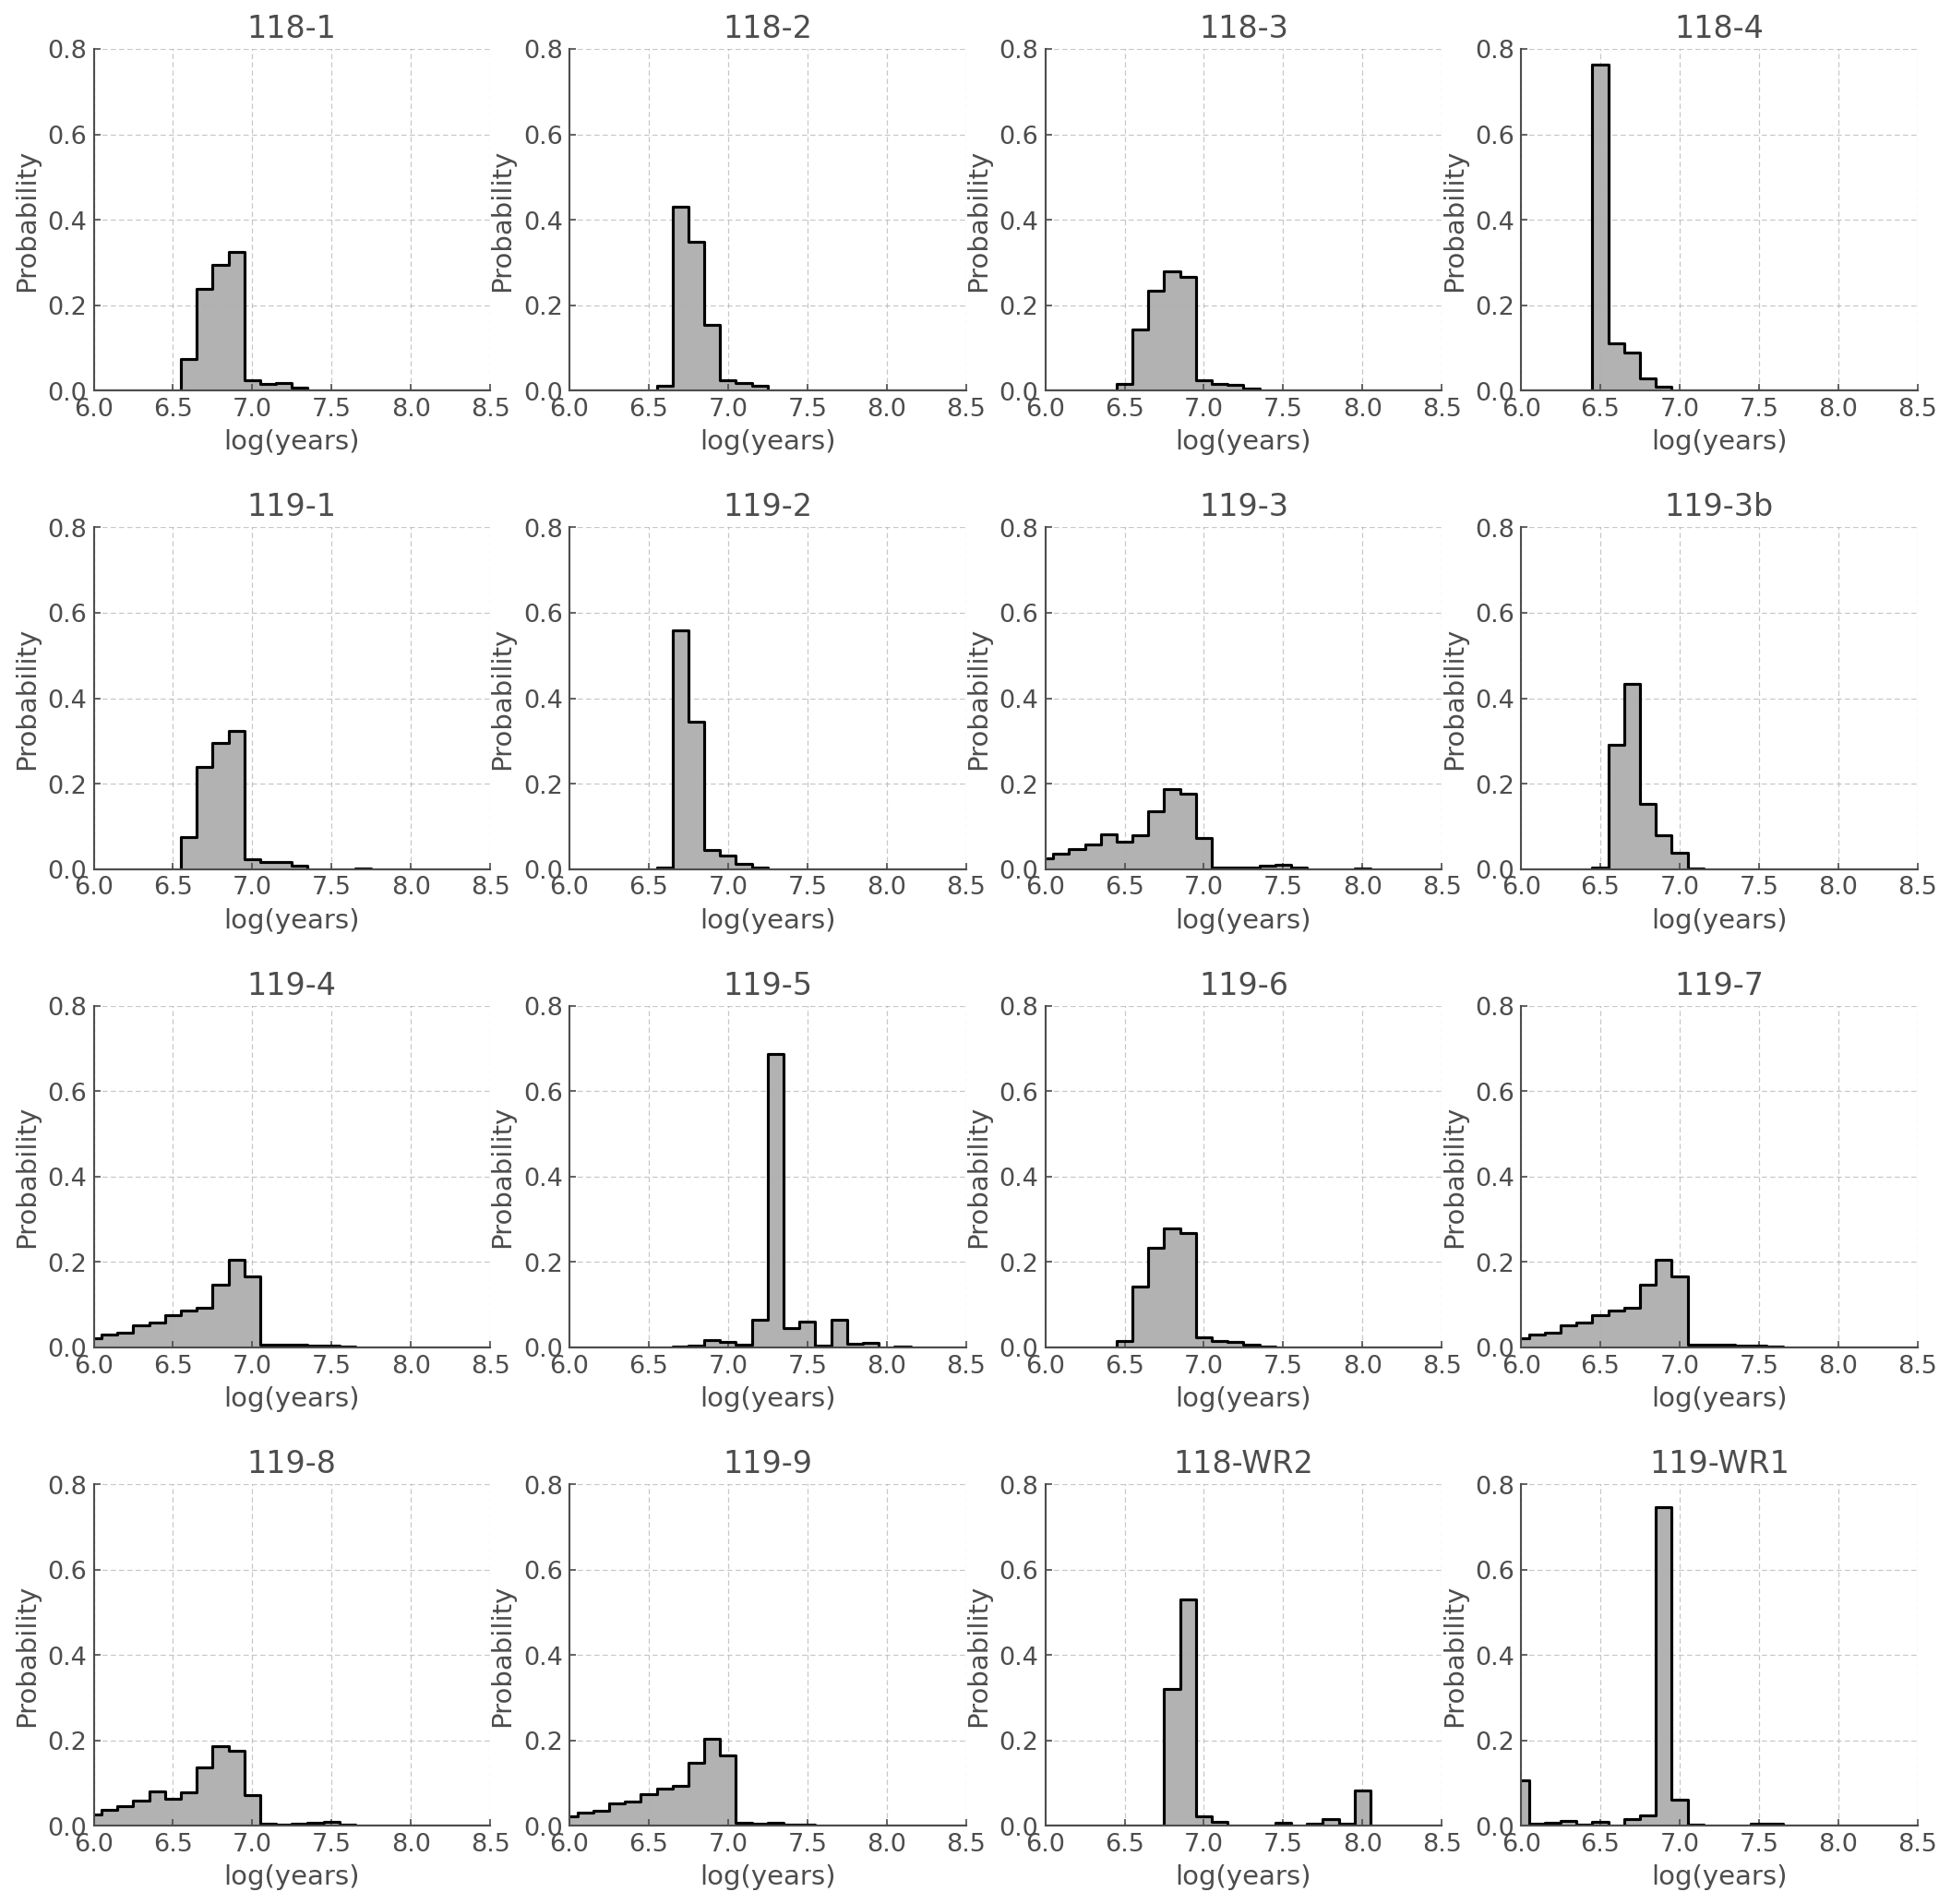

In [7]:
plot_all_pdfs(agewiz006, color='k')
#plt.savefig('pdfs_stars_z006.png', dpi=150)

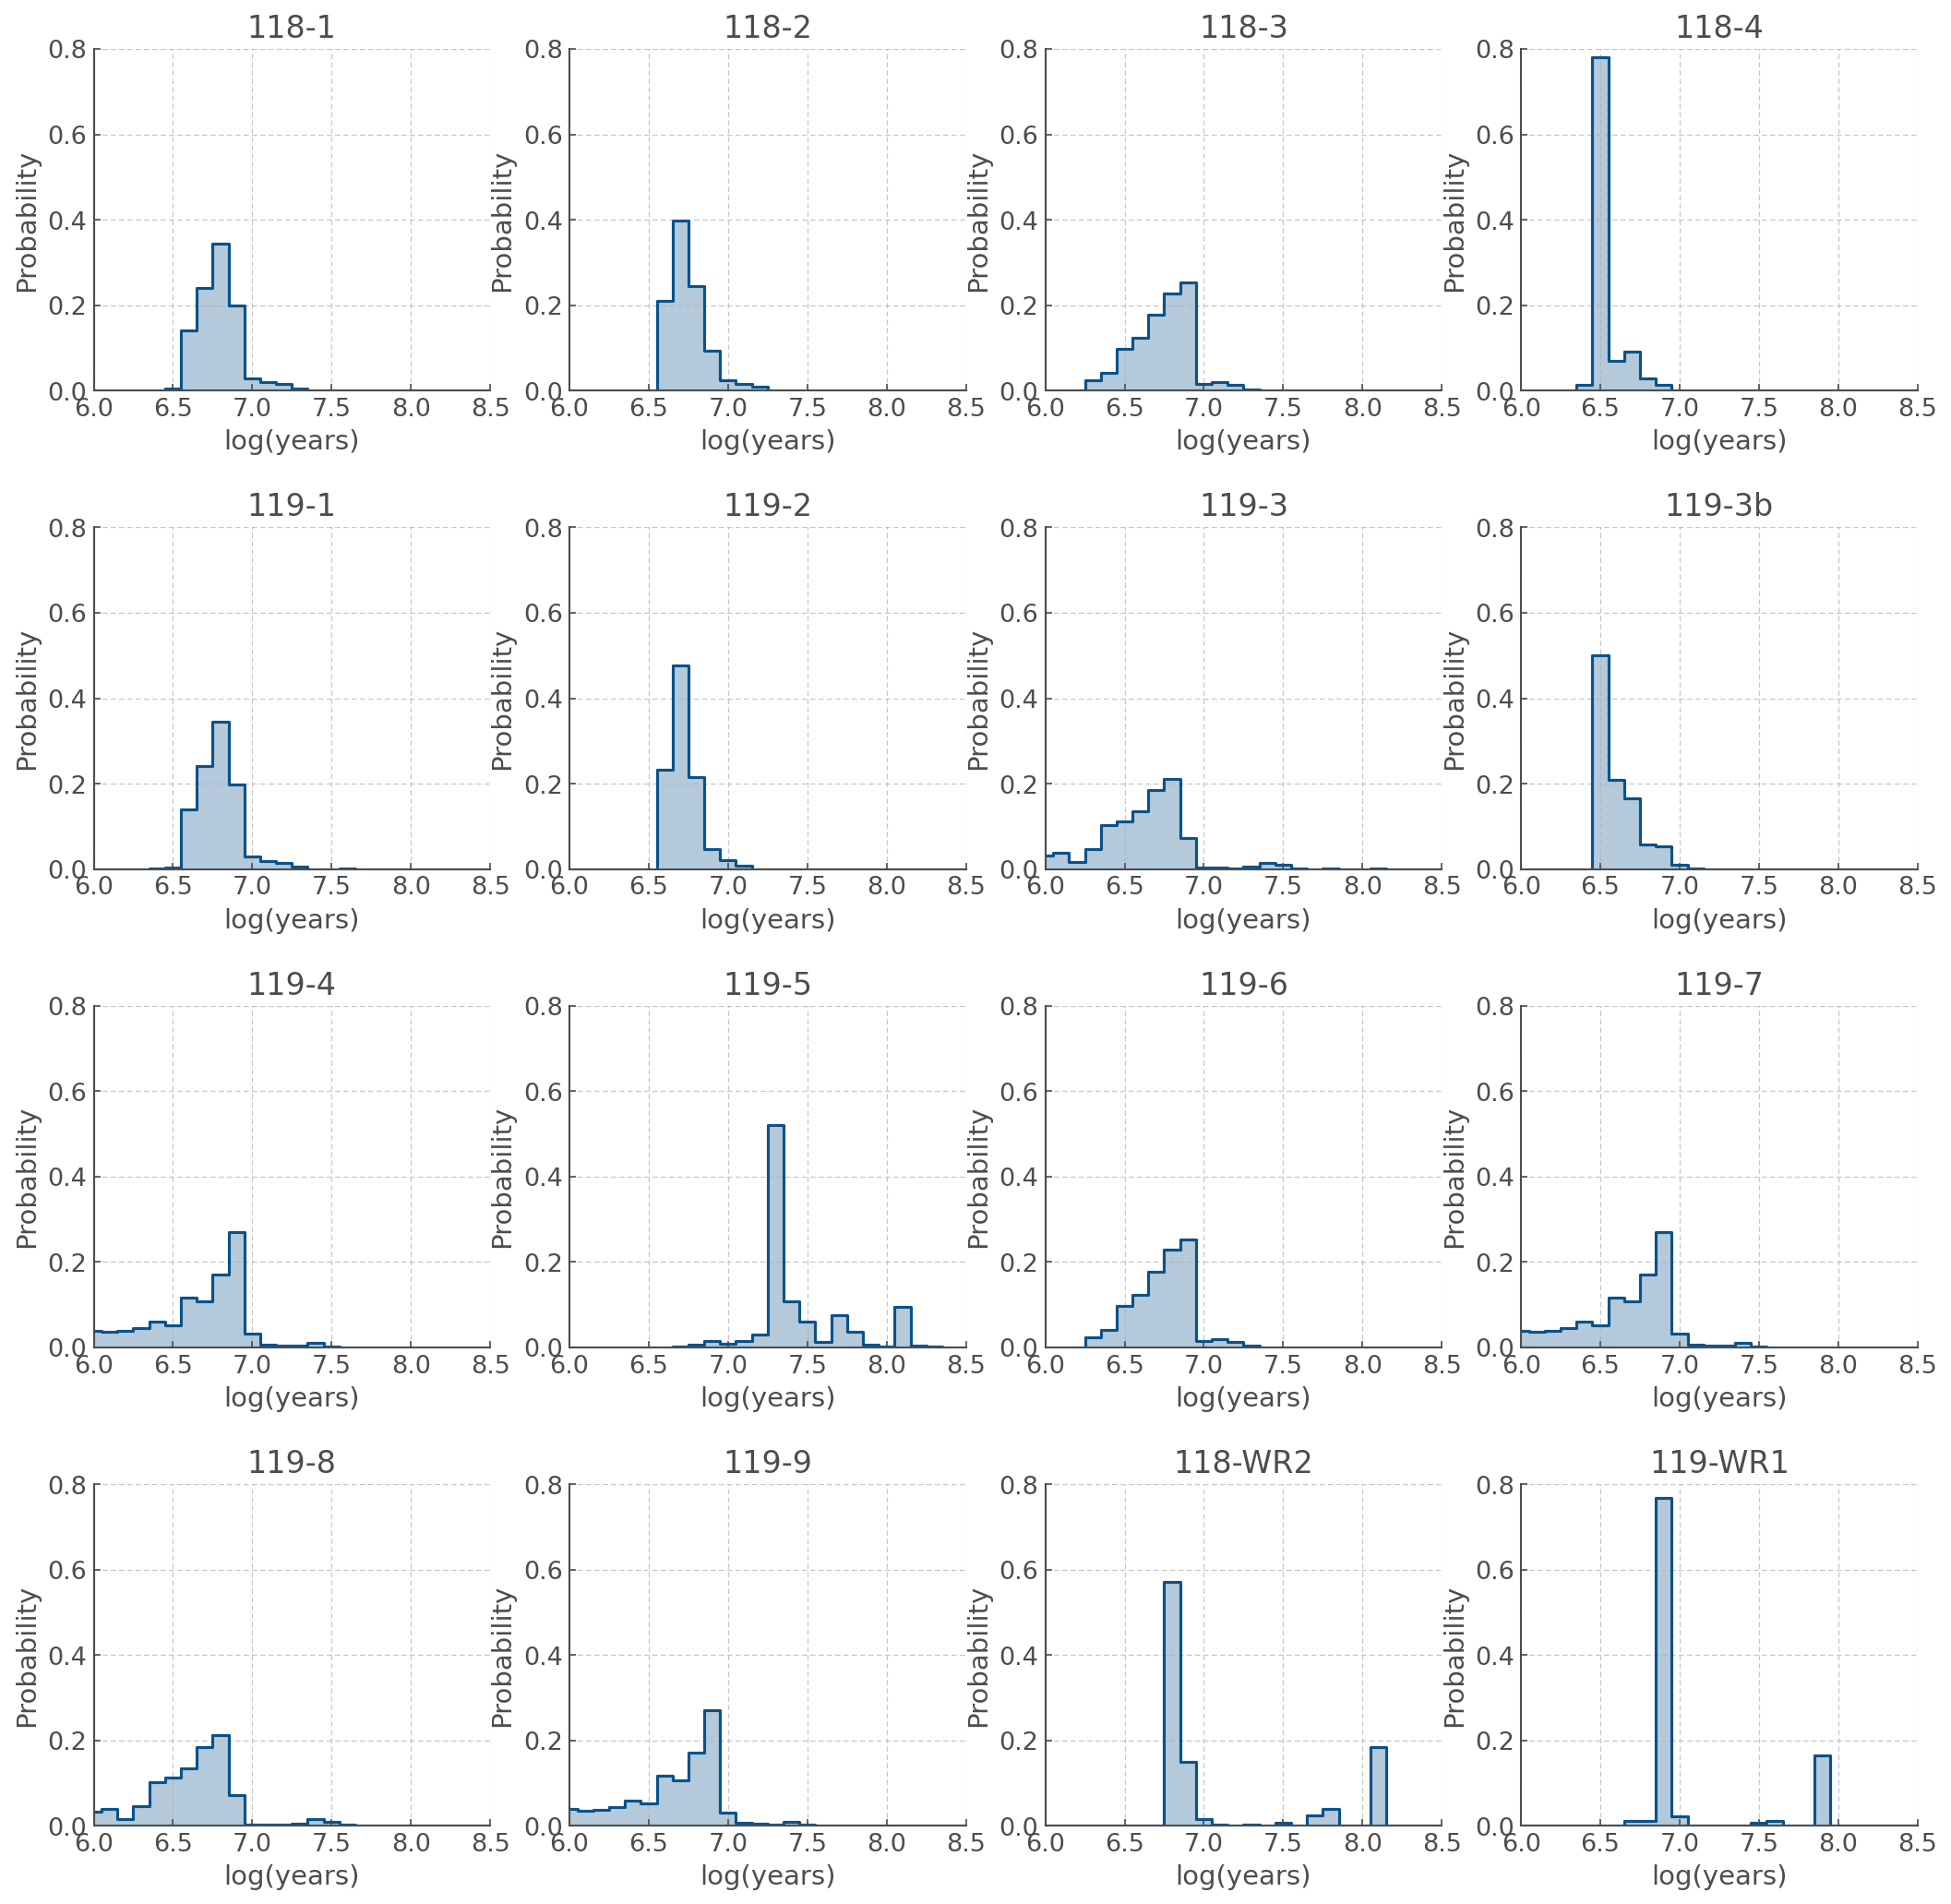

In [8]:
plot_all_pdfs(agewiz008, blues[5])
#plt.savefig('pdfs_stars_z008.png', dpi=150)

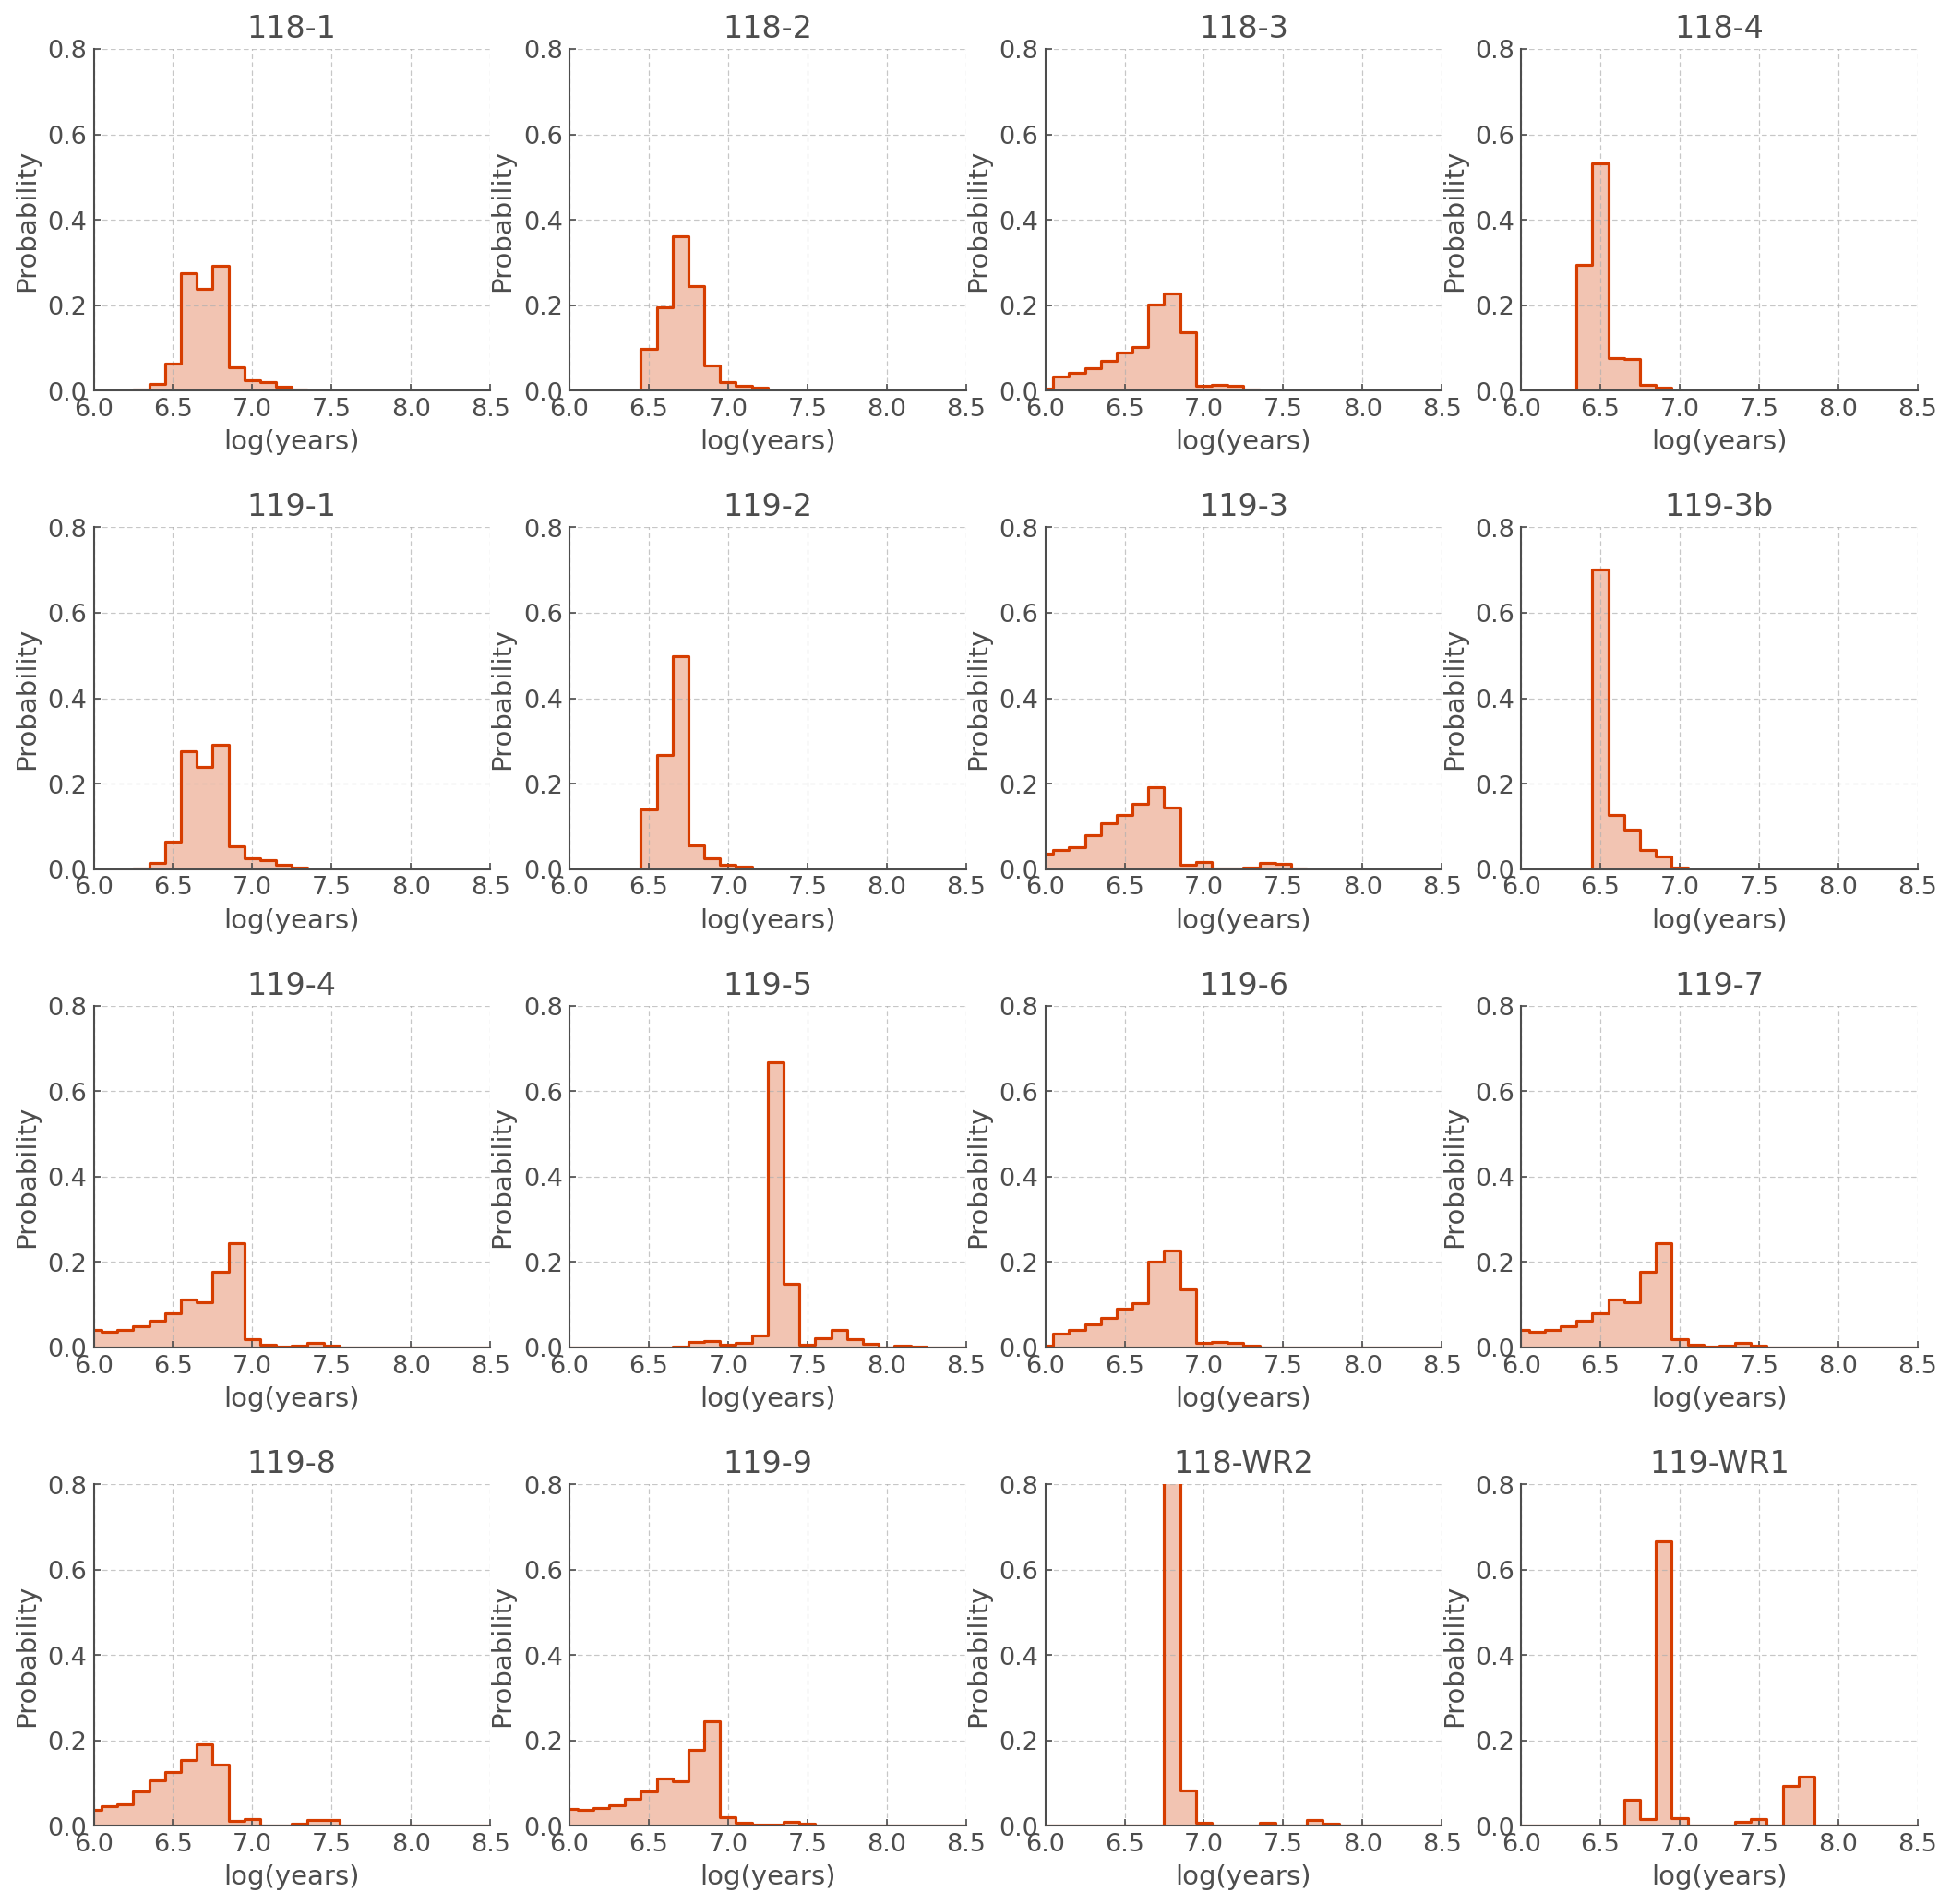

In [9]:
plot_all_pdfs(agewiz010, reds[5])
#plt.savefig('pdfs_stars_z010.png', dpi=150)

## Finding the most likely age reported in Table 1

For this we can just collate the most likely ages given my `AgeWizard` in a DataFrame

In [10]:
most_likely_ages = pd.DataFrame.from_dict({'name': agewiz006.sources, 
                                           'z006': agewiz006.most_likely_ages, 
                                           'z008': agewiz008.most_likely_ages,
                                           'z010': agewiz010.most_likely_ages}) 

In [11]:
most_likely_ages

,name,z006,z008,z010
0,118-1,6.9,6.8,6.8
1,118-2,6.7,6.7,6.7
2,118-3,6.8,6.9,6.8
3,118-4,6.5,6.5,6.5
4,119-1,6.9,6.8,6.8
5,119-2,6.7,6.7,6.7
6,119-3,6.8,6.8,6.7
7,119-3b,6.7,6.5,6.5
8,119-4,6.9,6.9,6.9
9,119-5,7.3,7.3,7.3


## Plotting $f_{118}(t)$, $f_{119}(t)$ and $f_{all}(t)$: Figure 4

As mentioned in Section 3.3 of Stevance et al in prep, we exclude D119-3 from our sample since it corresponds to the same source as D193-b.

We use `AgeWizard.calculate_sample_pdf()` to calculate the PDF of a whole sample. We can exclude sources using the `not_you` parameter and feeding in a list of star names to exclude. 
We create a list for D118 and D119, as well as D119-3.


In [12]:
d118 = ['118-1','118-2','118-3','118-4', '118-WR2']
d119 = ['119-1','119-2','119-3','119-3b','119-4','119-5','119-6','119-7','119-8','119-9', '119-WR1']
not_you= ['119-3', '118-4','119-5']

In [13]:
def plot_combined_pdfs(agewiz, ax, colour):
    """
    Given an AgeWizard object and a list of axes, will plot f_118, f_119 and f_all
    """
    pdf_118, pdf_119, pdf_all = [agewiz.calculate_sample_pdf(not_you=d119+not_you, return_df=True).pdf,
                                 agewiz.calculate_sample_pdf(not_you=d118+not_you, return_df=True).pdf,
                                 agewiz.calculate_sample_pdf(not_you=not_you, return_df=True).pdf]

    ax[0].step(BPASS_TIME_BINS, pdf_118, where='mid', alpha=0.8, color=colour)
    ax[0].fill_between(BPASS_TIME_BINS,  pdf_118, step='mid', alpha=0.1, 
                       color=colour, hatch='\\', label='dummy')

    ax[1].step(BPASS_TIME_BINS, pdf_119, where='mid', alpha=0.8, color=colour)
    ax[1].fill_between(BPASS_TIME_BINS,  pdf_119, step='mid', alpha=0.1, 
                       color=colour, hatch='\\', label='dummy')

    ax[2].step(BPASS_TIME_BINS, pdf_all, where='mid', alpha=0.8, color=colour)
    ax[2].fill_between(BPASS_TIME_BINS,  pdf_all, step='mid', alpha=0.1, 
                       color=colour, hatch='\\', label='dummy')
    
    # Labels
    for axis in ax:
        axis.set_ylabel('Probability')
        axis.set_xlabel('log(ages)')

    return

Text(7.5, 0.15, 'Z=0.010')

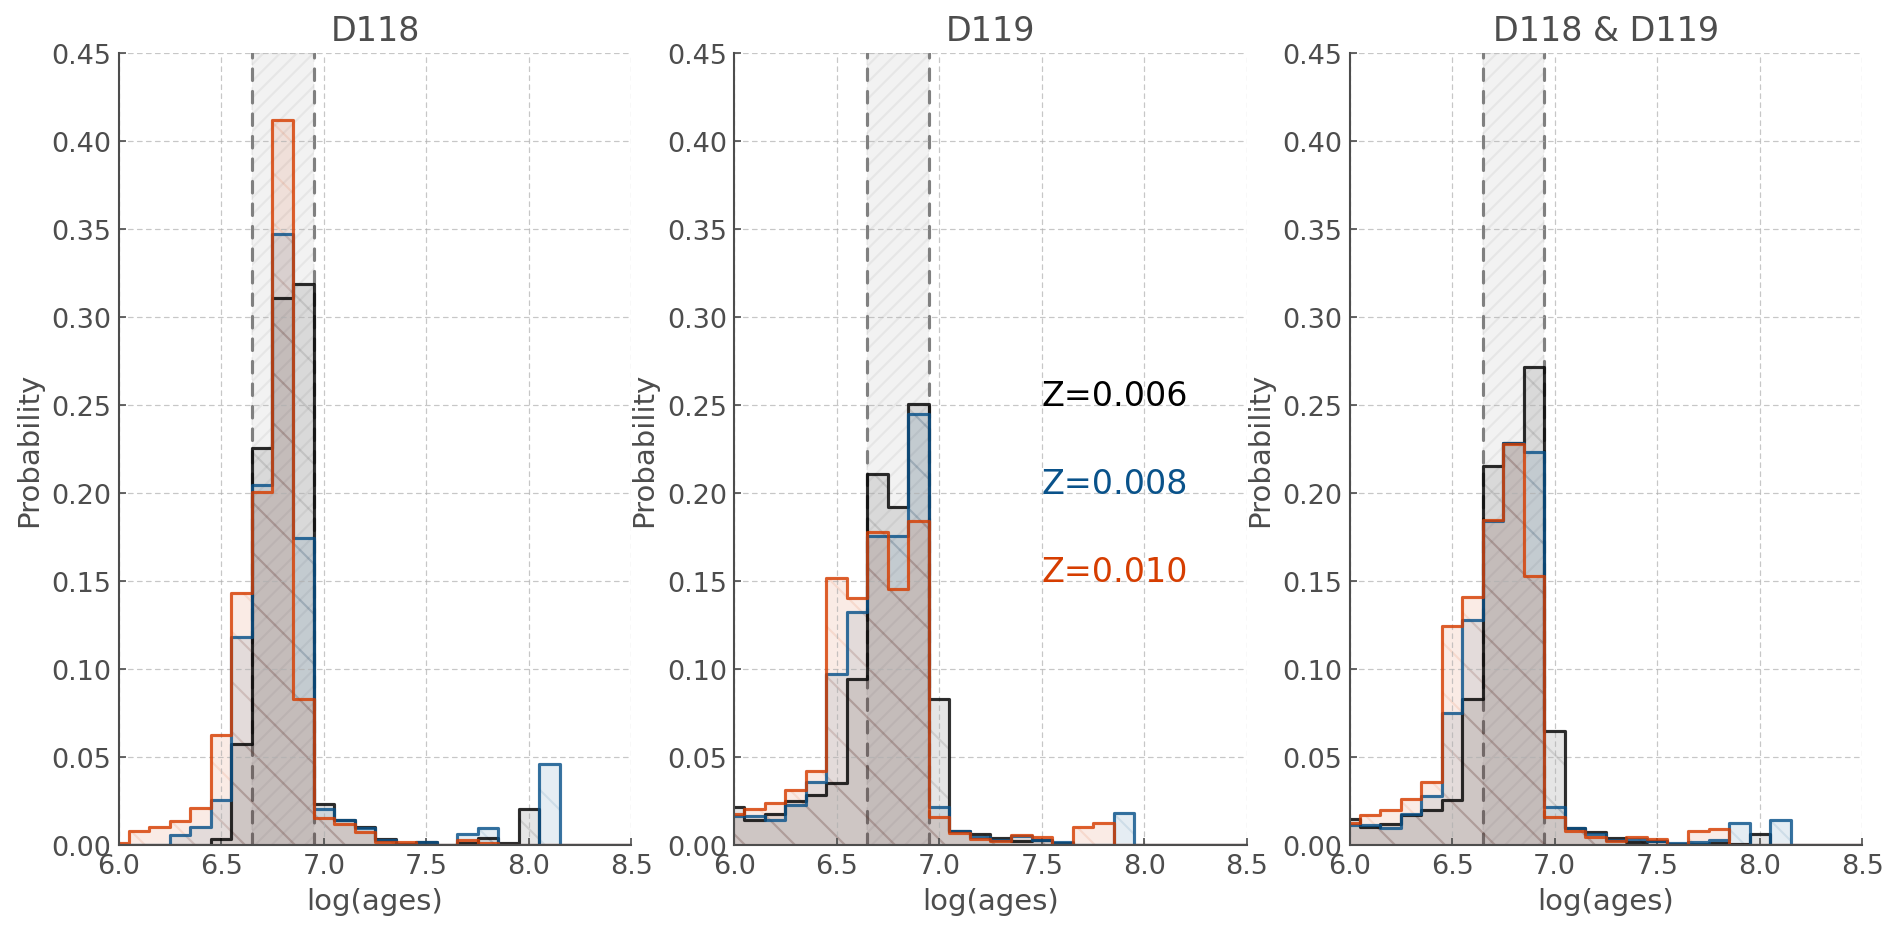

In [14]:
f, ax = plt.subplots(ncols=3, figsize=(15,7))
i=5 # just for colour

# Plotting
plot_combined_pdfs(agewiz006, ax, colour='k')
plot_combined_pdfs(agewiz008, ax, colour=blues[i])
plot_combined_pdfs(agewiz010, ax, colour=reds[i])

# Prettify
for axis in ax.reshape(3):
    # Crop
    axis.set_ylim([0,0.45])
    axis.set_xlim([6,8.5])
    
    # Highlight the region of most likely ages.
    axis.axvline(6.65, ls='--', c='grey', zorder=0.5)
    axis.axvline(6.95, ls='--', c='grey', zorder=0.5)
    axis.axvspan(6.65, 6.95, ls='--', color='grey',alpha=0.1, hatch='///', zorder=0.5)

# Titles
ax[0].set_title('D118')
ax[1].set_title('D119')
ax[2].set_title('D118 & D119')

# Metallicity legend
ax[1].text(7.5, 0.25, "Z=0.006", color='k', fontsize=16)
ax[1].text(7.5, 0.20, "Z=0.008", color=blues[i], fontsize=16)
ax[1].text(7.5, 0.15, "Z=0.010", color=reds[i], fontsize=16)


#plt.savefig('aggregate_pdfs.png', dpi=150)

By eye it's pretty clear that log(age/years) 6.7, 6.8 and 6.9 are the most likely. 
Let's do somethign quantitative. Here I re-order the PDFs in decreasing probability order and print the values of the top 4 bins. 

The top 3 are always 6.7, 6.8 and 6.9 (not necessarily in that order), i.e. index 7, 8, 9. 

I also sum the probabilities of these three bins for all Z and $f_{118}$, $f_{119}$, $f_{all}$. 

In [15]:
agewiz006.calculate_sample_pdf(not_you=d119+not_you)
agewiz008.calculate_sample_pdf(not_you=d119+not_you)
agewiz010.calculate_sample_pdf(not_you=d119+not_you)

print("Best aggregate D118 pdf Z=0.006")
print(agewiz006.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:4]) 
print("\np(6.7<=age<=6.9): ", agewiz006.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:3].sum().values[0])

print("\nBest aggregate D118 pdf Z=0.008")
print(agewiz008.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:4])
print("\np(6.7<=age<=6.9): ", agewiz008.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:3].sum().values[0])

print("\nBest aggregate D118 pdf Z=0.010")
print(agewiz010.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:4])
print("\np(6.7<=age<=6.9): ", agewiz010.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:3].sum().values[0])

Best aggregate D118 pdf Z=0.006
        pdf
9  0.318848
8  0.310832
7  0.225382
6  0.057426

p(6.7<=age<=6.9):  0.85506182104517

Best aggregate D118 pdf Z=0.008
        pdf
8  0.347296
7  0.204343
9  0.174241
6  0.118486

p(6.7<=age<=6.9):  0.7258809190118487

Best aggregate D118 pdf Z=0.010
        pdf
8  0.411639
7  0.200451
6  0.143194
9  0.083190

p(6.7<=age<=6.9):  0.7552840065265088


In [16]:
agewiz006.calculate_sample_pdf(not_you=d118+not_you)
agewiz008.calculate_sample_pdf(not_you=d118+not_you)
agewiz010.calculate_sample_pdf(not_you=d118+not_you)

print("Best aggregate D119 pdf Z=0.006")
print(agewiz006.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:4])
print("\np(6.7<=age<=6.9): ", agewiz006.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:3].sum().values[0])

print("\nBest aggregate D119 pdf Z=0.008")
print(agewiz008.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:4])
print("\np(6.7<=age<=6.9): ", agewiz008.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:3].sum().values[0])


print("\nBest aggregate D119 pdf Z=0.010")
print(agewiz010.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:4])
print("\np(6.7<=age<=6.9): ", agewiz010.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:3].sum().values[0])


Best aggregate D119 pdf Z=0.006
        pdf
9  0.250364
7  0.210706
8  0.191925
6  0.094569

p(6.7<=age<=6.9):  0.6529951868535853

Best aggregate D119 pdf Z=0.008
        pdf
9  0.244947
8  0.175793
7  0.175498
6  0.132436

p(6.7<=age<=6.9):  0.5962369883989587

Best aggregate D119 pdf Z=0.010
        pdf
9  0.184292
7  0.177677
5  0.151598
8  0.145803

p(6.7<=age<=6.9):  0.5135669346406211


In [17]:
agewiz006.calculate_sample_pdf(not_you=not_you)
agewiz008.calculate_sample_pdf(not_you=not_you)
agewiz010.calculate_sample_pdf(not_you=not_you)

print("Best aggregate D118 & D119 pdf Z=0.006")
print(agewiz006.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:4])
print("\np(6.7<=age<=6.9): ", agewiz006.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:3].sum().values[0])

print("\nBest aggregate D118 & D119 pdf Z=0.008")
print(agewiz008.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:4])
print("\np(6.7<=age<=6.9): ", agewiz008.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:3].sum().values[0])

print("\nBest aggregate D118 & D119 pdf Z=0.010")
print(agewiz010.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:4])
print("\np(6.7<=age<=6.9): ", agewiz010.sample_pdf.sort_values(by='pdf', 
                                    ascending=False).iloc[:3].sum().values[0])

Best aggregate D118 & D119 pdf Z=0.006
        pdf
9  0.271436
8  0.228512
7  0.215222
6  0.083140

p(6.7<=age<=6.9):  0.7151695358356113

Best aggregate D118 & D119 pdf Z=0.008
        pdf
8  0.228563
9  0.223191
7  0.184373
6  0.128144

p(6.7<=age<=6.9):  0.6361274285875401

Best aggregate D118 & D119 pdf Z=0.010
        pdf
8  0.227599
7  0.184685
9  0.153184
6  0.141222

p(6.7<=age<=6.9):  0.5654672875469784


## Probability that 6.7$\le$log(age/years)$\le$ 6.9 in Table 1

We can do this with an existing tool: `AgeWizard.calculate_p_given_age_range()`.
We collate the results at each Z in a DataFrame. 

In [18]:
p_ages_679 = pd.DataFrame.from_dict({'z006': agewiz006.calculate_p_given_age_range([6.7,6.9]), 
                                     'z008': agewiz008.calculate_p_given_age_range([6.7,6.9]),
                                     'z010': agewiz010.calculate_p_given_age_range([6.7,6.9])}) 

In [19]:
p_ages_679.round(3)

,z006,z008,z010
name,,,
118-1,0.858,0.784,0.585
118-2,0.932,0.738,0.668
118-3,0.780,0.659,0.564
118-4,0.127,0.135,0.095
119-1,0.858,0.784,0.585
119-2,0.949,0.738,0.577
119-3,0.500,0.469,0.346
119-3b,0.667,0.278,0.168
119-4,0.447,0.549,0.529


# 4.  STELLAR NUMBERS AND IONIZING FLUX
-----

To compare theory and observations we focus on the most luminous sources observed in [MC20](https://ui.adsabs.harvard.edu/abs/2020ApJ...891...25M/abstract) since this sample is most likely to be complete. By most luminous we mean stars with log(L) $\ge$ 4.9

For both D118 and D119 that is 6 stars (4 O stars + 2 WR stars).

We compare the WR/O star ratio in BPASS and in the observations to provide an independent estimate of the age to assess whether we find consistent answers with the analysis above. We can also estimate the mass of the clusters by scaling the total mass of stars in BPAASS (10$^6$ solar masses) by the ratio of observed to modelled O+WR stars.

In this part of the analysis we only consider the metallicity that is most consistent with NGC300 since the PoWR models are not involved in the star count. 

The errors given on the cluster mass and stellar numbers are calculated base on the Poisson errors on the observed numbers of O and WR stars.

## Mass and Stellar numbers

First we load the stellar number output from BPASS at the metallicity of interest. Here we focus on the metallicity closest to NGC 300.

In [20]:
nmbrs_006 = load.model_output('./data/numbers-bin-imf135_300.z006.dat')

In [21]:
def fiducial_imf(upper_mass, mass_res=0.1):
    """ IMF """
    low_imf = np.arange(0.1, 0.5, mass_res)**(-1.3)
    high_imf = (np.arange(0.5, upper_mass, mass_res)*0.5)**(-2.35)
    return np.concatenate((low_imf, high_imf))

mass_range = np.arange(0.1, 300, 0.1)
fiducial = fiducial_imf(300)

def tot_WRO_stars(df):
    """
    Counts the total number of WR and O stars in the model then calculates WR/O and the cluster mass
    """
    
    # Stellar Counts
    # uncomment the end of these lines if you want to see what happens when the lower luminosity stars are included
    df['WR_tot'] = df.WC_hL + df.WN_hL  + df.WNH_hL # + df.WC_lL + df.WN_lL  + df.WNH_lL 
    df['O_tot'] = df.O_hL + df.Of_hL # + df.O_lL + df.Of_lL 
    
    # Stellar count ratios
    df['O/WR'] = df['O_tot'].values/df['WR_tot'].values
    df['WR/O'] = 1.0/df['O/WR'].values
    
    # Total number of O+WR stars
    df['OWRtot'] = df['O_tot'].values+df['WR_tot'].values
    
    # Cluster mass and error
    df['cluster_mass'] = (6/df['OWRtot'].values)*10**6  
    df['cluster_mass_e'] = (np.sqrt(6)/df['OWRtot'].values)*10**6 # poisson
    return df

def tot_star_number(df):
    """
    Finds the total number of stars based on count of massive stars and the IMF
    """
    star_numbers=[]
    star_numbers_e=[]
    for i in range(df.shape[0]):
        scale_imf = df.iloc[i,6]/sum([number* mass for number, mass in zip(fiducial, 
                                                                               np.arange(0.1, 100, 0.1))])
        scale_imf_e = df.iloc[i,7]/sum([number* mass for number, mass in zip(fiducial, 
                                                                               np.arange(0.1, 100, 0.1))])       
        scaled_fiducial = fiducial*scale_imf
        scaled_fiducial_e = fiducial*scale_imf_e
        star_numbers.append(sum(scaled_fiducial))
        star_numbers_e.append(sum(scaled_fiducial_e))
        
    df['all_stars_number'] = star_numbers
    df['all_stars_number_e'] = star_numbers_e
    
    return df

In [22]:
# Calculating the Stellar counts, ratios and cluster mass.

# Note: We expect divide by 0 warnings since at later ages ther will be no O stars and the calculation 
# of the WR/O stars will therefore tend to infinity. We cut out all ages above log(age) = 7.3 because of this.

nmbrs_006 = tot_WRO_stars(nmbrs_006)
nmbrs_006 = nmbrs_006.drop(nmbrs_006.columns.to_list()[1:-7], axis=1)

nmbrs_006 = nmbrs_006[nmbrs_006.log_age <7.4]
nmbrs_006  = tot_star_number(nmbrs_006)
nmbrs_006.head() 

/home/fste075/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/fste075/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/fste075/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/fste075/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/fste075/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


,log_age,WR_tot,O_tot,O/WR,WR/O,OWRtot,cluster_mass,cluster_mass_e,all_stars_number,all_stars_number_e
0,6.0,0.000000,1855.0944,inf,0.000000,1855.094400,3234.336754,1320.412451,2789.225303,1138.696461
1,6.1,0.112632,2028.1090,1.800654e+04,0.000056,2028.221632,2958.256586,1207.703194,2551.139460,1041.498323
2,6.2,0.984710,2045.7130,2.077478e+03,0.000481,2046.697710,2931.551626,1196.800940,2528.109654,1032.096444
3,6.3,14.091112,2156.1279,1.530133e+02,0.006535,2170.219012,2764.697925,1128.683202,2384.218464,973.353112
4,6.4,72.362946,2045.4162,2.826607e+01,0.035378,2117.779146,2833.156617,1156.631345,2443.255827,997.455015


### Numbers summarised in Table 2

In [23]:
nmbrs_006_age_crop = nmbrs_006[(nmbrs_006.log_age>6.5) & (nmbrs_006.log_age<7.1)]

tab2 = pd.DataFrame.from_dict({'log_age': nmbrs_006_age_crop.log_age.values, 
                               
                               'logM': np.round(np.log10(nmbrs_006_age_crop.cluster_mass.values), 2), 
                               
                               'logM_e+': np.round(np.log10(nmbrs_006_age_crop.cluster_mass.values+
                                                            nmbrs_006_age_crop.cluster_mass_e.values)-
                                                   np.log10(nmbrs_006_age_crop.cluster_mass.values), 2),
                               
                               'logM_e-': np.round(np.log10(nmbrs_006_age_crop.cluster_mass.values)-
                                                   np.log10(nmbrs_006_age_crop.cluster_mass.values-
                                                            nmbrs_006_age_crop.cluster_mass_e.values), 2),   
                               
                               'N/1000': np.round((nmbrs_006_age_crop.all_stars_number.values/1000),2),
                               
                               'N_e/1000': np.round((nmbrs_006_age_crop.all_stars_number_e.values/1000),2),
                               
                               'WR/O': np.round(nmbrs_006_age_crop['WR/O'].values,2)
                              })

tab2

,log_age,logM,logM_e+,logM_e-,N/1000,N_e/1000,WR/O
0,6.6,3.52,0.15,0.23,2.86,1.17,0.07
1,6.7,3.62,0.15,0.23,3.59,1.46,0.08
2,6.8,3.80,0.15,0.23,5.49,2.24,0.15
3,6.9,4.30,0.15,0.23,17.10,6.98,0.73
4,7.0,4.65,0.15,0.23,38.40,15.68,2.35


## Ages estimate based on WR/O

Using traditional Poisson errors and a standard error propagation method assuming the errors on the two values are not correlated, we would find a WR/O star ratio of 0.50$\pm$0.43.

As described in Appendix B of the paper however, we use the method described in [Dron-Wallenstein et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896..164D/abstract).

We have implemented the computational methods into `hoki` with the permission of Dorn-Wallenstein (priv. communication). If you use the `hoki` infrasctructure to implent this method in your own analysis, please make sure to cite their paper in additon to the normal `hoki` references so that they get the credit they deserve :)

The method basically uses the osberve stellar number counts and MCMC simulations to retrieve the underlying number count ratio. We use the default values implemented in `UnderlyingCountRatio.run_emcee()

```
nwalkers=100, nburnin=500, nsteps=3000, ci_width=68.0
```

Where `ci_width` is the width of the confidence interval in percent. The default is 68 to mimic 1 sigma errors. 

In [24]:
from hoki.stats.starcounts import UnderlyingCountRatio

In [25]:
# Instanciating the UnderlyingCountRatio object with the numebr of WR stars and number of O stars (2 and 4)
WRO_ratio = UnderlyingCountRatio(2,4, name="WR/O")

In [26]:
# Now running the MCMC with default parameters.
# This is where you could parse different values for the parameters
# nwalkers, nburnin, nsteps,and ci_width
WRO_ratio.run_emcee()

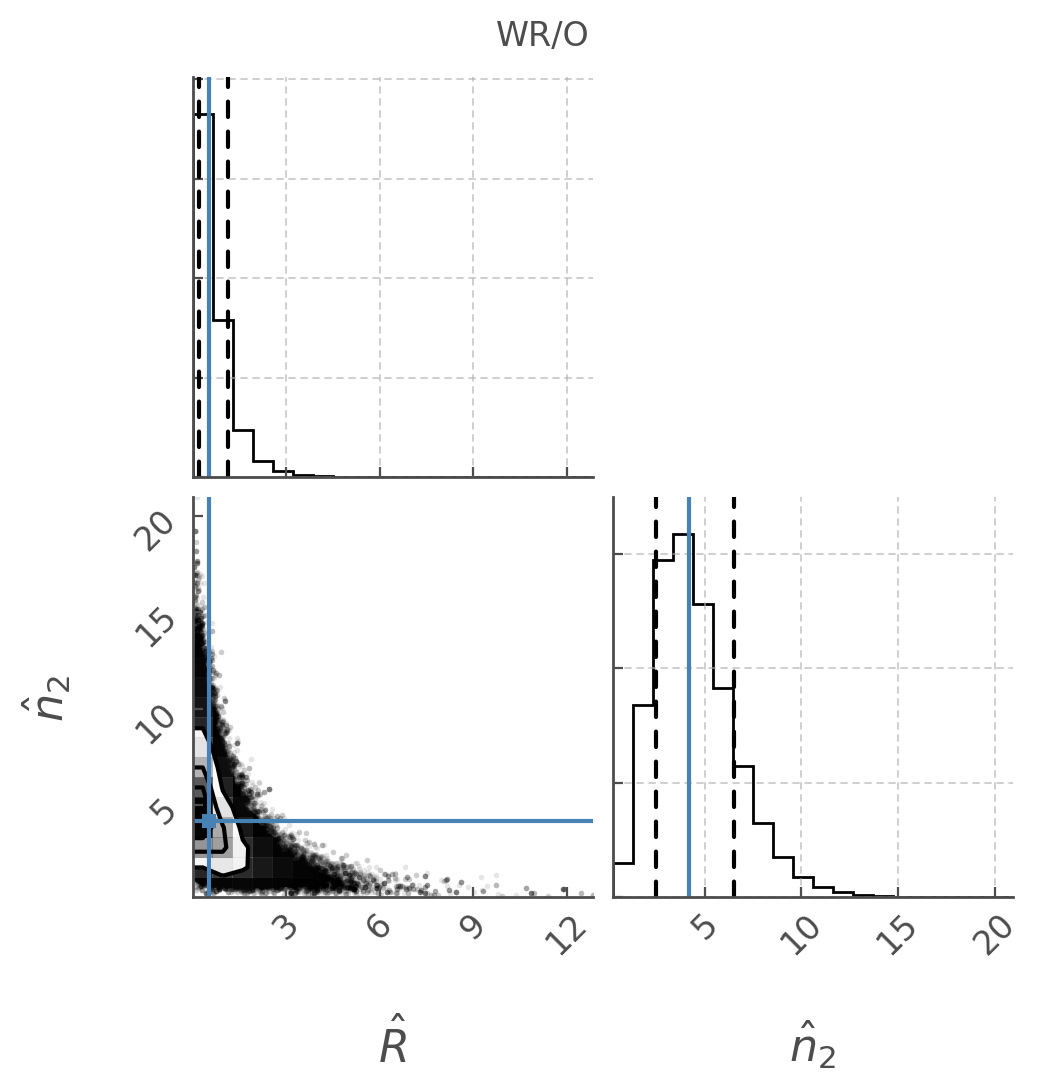

In [27]:
# Now we plot and save the figure to a file
WRO_ratio.corner_plot(output_file="WRO_corner.png")

In [28]:
# You can also call a summary table :D

WRO_ratio.results_summary

,Variable,16th,50th,84th
0,R_hat,0.2982,0.5174,0.6331
1,n2_hat,1.6997,2.3507,4.1763


In [29]:
WRO, WRO_hi, WRO_lo = WRO_ratio.R_hat

In [30]:
print(f"The WR/O ratio is {round(WRO,2)} +{round(WRO_hi-WRO, 3)}/-{round(WRO-WRO_lo,3)}")

The WR/O ratio is 0.52 +0.116/-0.219


Note that these numbers will vary slightly every time you run the MCMC, so don't worry if your numbers are a tad different from the ones in the paper when you run this notebook.

Now we want to find the age that brings us closest to this WR/O star ratio, and in order to do that we will interpolate the WR/O star function, rather than select the closest BPASS time bin (since the BPASS time bin resolution is 0.1 dex).

A linear interpolation is used. 


In [31]:
# Interpolation 
interp_ages = np.arange(6.0,7.3,0.001)
interp_WRO_ratio = np.interp(interp_ages, nmbrs_006.log_age.values, nmbrs_006['WR/O'].values)

Text(0.5, 0, 'log(age)')

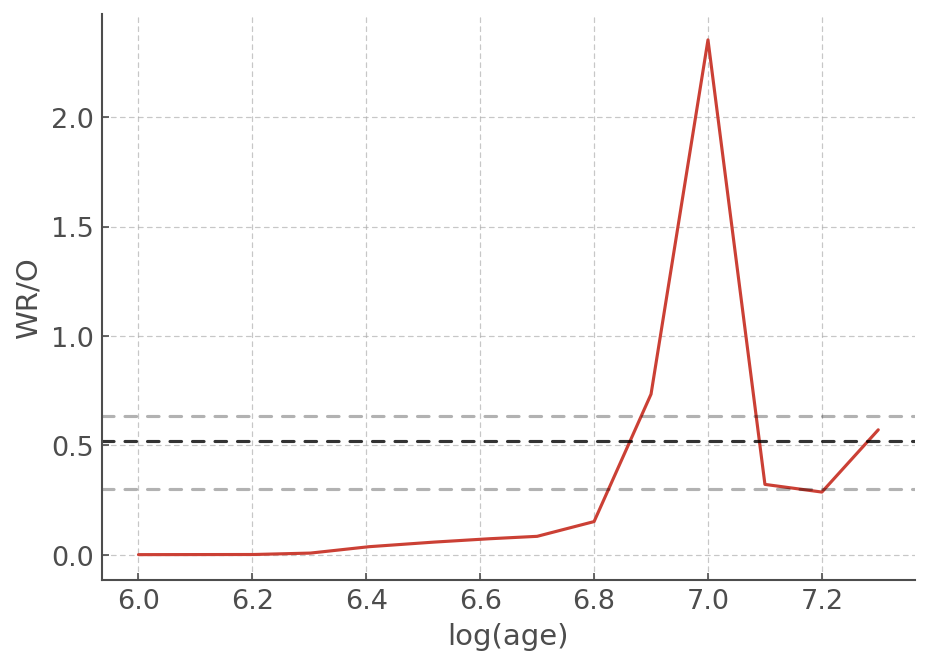

In [32]:
# Let's plot it!
plt.plot(interp_ages, interp_WRO_ratio)
plt.axhline(WRO, ls='--', color='k', alpha=0.8)
plt.axhline(WRO_hi, ls='--', color='k', alpha=0.3)
plt.axhline(WRO_lo, ls='--', color='k', alpha=0.3)
plt.ylabel('WR/O')
plt.xlabel('log(age)')

It is interesting to note that the WR/O ratio decreases sharply after log(age)=7.0 but then seems to pick up again towards log(age)=7.3. This is a features of the luminosity cut off we have applied, and ages much beyond log(age) = 7.0 are not realistic since most O stars and WR stars do not live beyond 10 Myrs. 

Therefore we only consider the first (in time space) match to the WR/O star ratio - in order to do this we will simply apply a mask to cut-off everything beyond 7.0.

In [33]:
def _interp_index(interpolated, nearest):    
    return np.where(abs(interpolated-nearest) == abs(interpolated-nearest).min())[0]

def interpolation_with_error(to_find, to_use, target, err1, err2):

    ind = _interp_index(to_use, target)
    ind_p = _interp_index(to_use, target+err1)
    ind_m = _interp_index(to_use, target-err2)

    return float(to_find[ind]), float(to_find[ind_p]), float(to_find[ind_m])

In [34]:
mask = (interp_ages < 7.0)
age, age_p, age_m = interpolation_with_error(interp_ages, interp_WRO_ratio[mask], WRO, WRO_hi, WRO_lo)

age_err1 = age_p-age
age_err2 = age-age_m
print(f"The age estimate is therefore: {round(age,2)} (+{round(age_err1,2)}/-{round(age_err2,2)})")

The age estimate is therefore: 6.86 (+0.06/-0.05)


## Mass based on WR/O ratio

Now that we have an age estimate from the WR/O star ratio, and given that we have mass estimates on the cluster at different ages (see tab2), we can combine the two to find a mass estimate at our estimate age. 

Because we need to take into account the fact that the uncertainties on the age span multiple age bins, and the fact that there are uncertainties on the estimated mass, we're once again going to do an interpolation, but this time we will do it 3 times:

- For the nominal values of the mass estimate
- For their upper uncertainty value
- For their lower uncertainty value

In [35]:
# Nominal value of mass estimate interpolation
interp_masses = np.interp(interp_ages, nmbrs_006.log_age.values, nmbrs_006['cluster_mass'].values)
mass, __, __ = interpolation_with_error(interp_masses, interp_ages, age, age_err1, age_err2)

log_m = np.log10(mass)

# Upper mass estimate interpolation
interp_masses = np.interp(interp_ages, nmbrs_006.log_age.values, nmbrs_006['cluster_mass'].values+nmbrs_006['cluster_mass_e'].values)
__, mass_p, __ = interpolation_with_error(interp_masses, interp_ages, age, age_err1, age_err2)

log_m_p = np.log10(mass_p)

# Lower mass estimate interpolation
interp_masses = np.interp(interp_ages, nmbrs_006.log_age.values, nmbrs_006['cluster_mass'].values-nmbrs_006['cluster_mass_e'].values)
__, __,  mass_m = interpolation_with_error(interp_masses, interp_ages, age, age_err1, age_err2)

log_m_m = np.log10(mass_m)

np.log10(mass), np.log10(mass_p)-np.log10(mass), np.log10(mass)-np.log10(mass_m)

(4.171683609315901, 0.39614199281629325, 0.49731082603912613)

In [36]:
print(f"The mass estimate is therefore: {round(log_m,2)} (+{round(log_m_p - log_m,2)}/-{round(log_m - log_m_m,2)})")

The mass estimate is therefore: 4.17 (+0.4/-0.5)


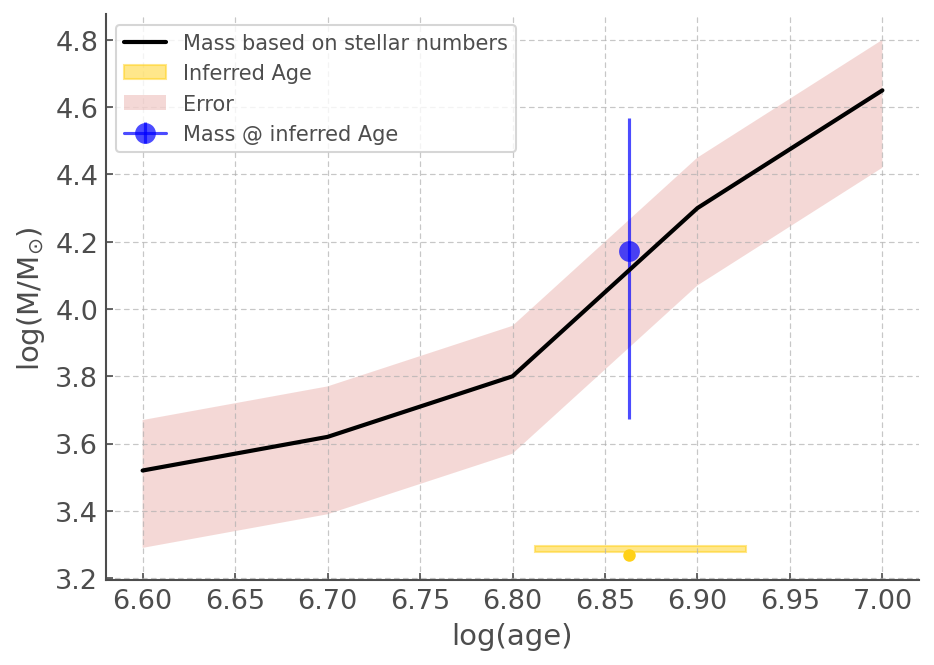

In [37]:
plt.plot(tab2.log_age,tab2.logM, c='k', lw=2, label='Mass based on stellar numbers')
plt.fill_between(tab2.log_age, tab2.logM-tab2['logM_e-'], tab2.logM+tab2['logM_e+'], alpha=0.2, label='Error')
plt.axvspan(age_m, age_p, ymin=0.05, ymax=0.06, color=yellow, alpha=0.5, label='Inferred Age')
plt.scatter(age,3.27, c=yellow, s=100)
plt.errorbar(age, np.log10(mass), yerr=[[np.log10(mass)-np.log10(mass_m)], [np.log10(mass_p)-np.log10(mass)]],
            marker='o', markersize=10, color='blue', alpha=0.7, label='Mass @ inferred Age')

plt.xlabel('log(age)')
plt.ylabel(r'log(M/M$_{\odot}$)')

plt.legend()

Indeed the large uncertainties reflect the estimated mass function, its uncertainties, and the large uncertainty on the age, particularly to lower ages. 

This is to be expected given that this is all derived from a low number of observed stars.

# Ionization photon flux and cluster mass

MC19 provide in their Table 6 the ionizing photon flux emitted by the massive stars in the subregions they identified. We can compare these values to the ionizing photon flux in the BPASS models to once again scale the stellar mass in the BPASS models (10$^6$) to estimate the total mass in the D118 and D119 regions. 

### Observed ionizing photon flux

In [38]:
# We need to combine the ionizing photon flux of the sub regions 118A and 119B

# These values from Table 6 of MC19
logQHa_118a = 49.90 
logQHa_118b = 49.01

# Need to take them out of log space to add them together and then log again.
logQHa118 = np.log10(10**logQHa_118a + 10**logQHa_118b)

print(f"Ionizig photon flux for D118: {round(logQHa118,2)}")

# We need to combine the ionizing photon flux of the sub regions 119A, 119B and 119C

# These values from Table 6 of MC19
logQHa_119a = 50.15
logQHa_119b = 49.49
logQHa_119c = 49.19

logQHa119 = np.log10(10**logQHa_119a + 10**logQHa_119b + 10**logQHa_119c)

print(f"Ionizig photon flux for D119: {round(logQHa119,2)}")

Ionizig photon flux for D118: 49.95
Ionizig photon flux for D119: 50.27


### Modelled ionizing photon flux

In [39]:
ion = load.model_output('./data/ionizing-bin-imf135_300.z006.dat')
ion = ion[(ion.log_age >6.0) & (ion.log_age<7.3)]

ion.head()

,log_age,prod_rate,halpha,FUV,NUV
1,6.1,52.92814,41.05814,39.18613,38.71882
2,6.2,52.90179,41.03179,39.24476,38.80001
3,6.3,52.81953,40.94953,39.30114,38.90032
4,6.4,52.74383,40.87383,39.27453,38.88850
5,6.5,52.58476,40.71476,39.15036,38.74286


The production rate is the ionizing photon flux.

In [40]:
# interpolating the values of the ionizing photon flux like we did the WR/O star ratio above.
interp_prod_rate=np.interp(interp_ages, ion.log_age.values, ion.prod_rate.values)
QHa, QHa_p, QHa_m = interpolation_with_error(interp_prod_rate, interp_ages, age, age_err1, age_err2)

In [41]:
def mass_calc(model, obs):
    """This just calculates the scale factor and applies it to the BPASS mass to return cluster mass"""
    return (10**obs/10**(model)) * 10**6

In [42]:
mass_calc(QHa_p, logQHa118), mass_calc(QHa, logQHa118), mass_calc(QHa_m, logQHa118)

log_mass_p = np.log10(mass_calc(QHa_p, logQHa118))
log_mass = np.log10(mass_calc(QHa, logQHa118))
log_mass_m = np.log10(mass_calc(QHa_m, logQHa118))
print(f"The D118 cluster mass is \n"
f"10E[{round(log_mass,2)}(+{round(log_mass_p-log_mass, 2)}/-{round(log_mass-log_mass_m, 2)})] Solar masses")

log_mass_p = np.log10(mass_calc(QHa_p, logQHa119))
log_mass = np.log10(mass_calc(QHa, logQHa119))
log_mass_m = np.log10(mass_calc(QHa_m, logQHa119))
print(f"The D119 cluster mass is \n"
f"10E[{round(log_mass,2)}(+{round(log_mass_p-log_mass, 2)}/-{round(log_mass-log_mass_m, 2)})] Solar masses")


The D118 cluster mass is 
10E[4.36(+0.2/-0.18)] Solar masses
The D119 cluster mass is 
10E[4.68(+0.2/-0.18)] Solar masses


## Histograms

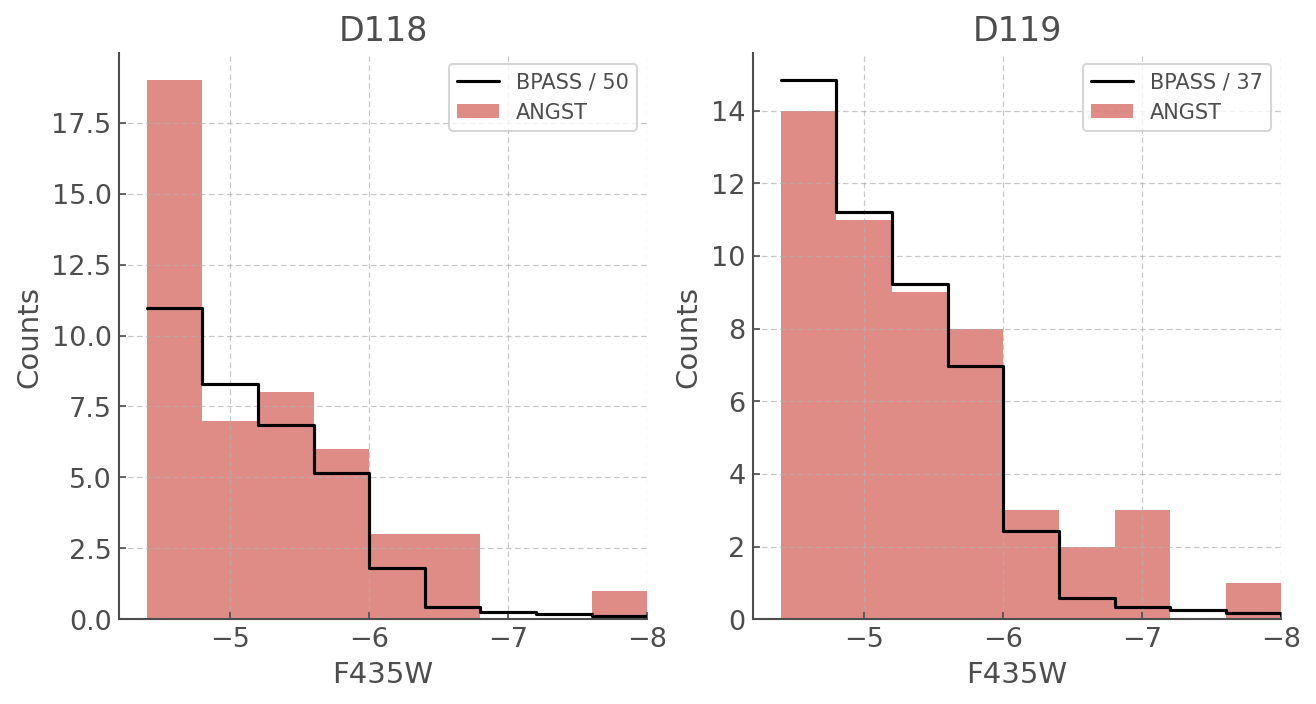

In [43]:
bpass_cmd = load.unpickle('./data/ngc300_CMD.pckl')
cmd_118 = pd.read_csv('./data/cmd_data_118.dat')
cmd_119 = pd.read_csv('./data/cmd_data_119.dat')

bins = bpass_cmd.mag_range[bpass_cmd.mag_range < -4.0]
bins[::2]

bpass_counts = bpass_cmd.at_log_age(6.9).sum(axis=1)[bpass_cmd.mag_range < -4.0]
arr = np.zeros(48)
arr = bpass_counts[0:-1:4] + bpass_counts[1::4] + bpass_counts[2::4] + bpass_counts[3::4]  + bpass_counts[4::4] 

weight = BPASS_TIME_INTERVALS[np.round(BPASS_TIME_BINS,1)==6.9]


f, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].hist(cmd_118.F435W[cmd_118.F435W<-3.94], bins = bins[:-1:4], alpha=0.6, label='ANGST')
ax[0].set_xlim([-3.4,-8.0])
ax[0].set_xlabel("F435W")
ax[0].set_ylabel("Counts")
ax[0].set_title("D118")
ax[0].step(bins[:-1:4], arr/weight/50, color='k',  label='BPASS / 50') #8.10e7
ax[0].set_xlim([-4.2,-8.0])
ax[0].legend()

ax[1].hist(cmd_119.F435W[cmd_119.F435W<-3.94], bins = bins[:-1:4], alpha=0.6, label='ANGST')
ax[1].set_xlim([-3.4,-8.0])
ax[1].set_xlabel("F435W")
ax[1].set_ylabel("Counts")
ax[1].set_title("D119")
ax[1].step(bins[:-1:4], arr/weight/(37), color='k', label='BPASS / 37') #6.10e7
ax[1].set_xlim([-4.2,-8.0])
ax[1].legend()


#plt.savefig("hist_agnst_vs_BPASS.png", dpi=250)

In [44]:
np.log10(1e6/50), np.log10(1e6/37)

(4.301029995663981, 4.431798275933005)

# BPT Diagrams

In [45]:
names = np.array(['118A', '118B', '119A', '119B', '119C'])
OIII_Hb_obs = np.array([2.41, 1.39, 1.61, 0.77, 2.79])
NII_Ha_obs = np.array([0.16, 0.24, 0.20, 0.24, 0.22])
SII_Ha_obs = np.array([0.155, 0.285, 0.178, 0.205, 0.235])

sources_bpt = pd.DataFrame.from_dict({'name': names, 
                                      'OIII_Hb': np.log10(OIII_Hb_obs), 
                                      'NII_Ha': np.log10(NII_Ha_obs), 
                                      'SII_Ha': np.log10(SII_Ha_obs)})

In [46]:
# LOADING IN NEBULAR EMISSION LINE MODELS (XIAO+18)

nebular_lines_bin_006 = load.nebular_lines('/home/fste075/Data/bpass_nebular/Optical/bin/Optical_data_bin_z006.dat')
nebular_lines_sin_006 = load.nebular_lines('/home/fste075/Data/bpass_nebular/Optical/sin/Optical_data_sin_z006.dat')

nebular_lines_bin_008 = load.nebular_lines('/home/fste075/Data/bpass_nebular/Optical/bin/Optical_data_bin_z008.dat')
nebular_lines_sin_008 = load.nebular_lines('/home/fste075/Data/bpass_nebular/Optical/sin/Optical_data_sin_z008.dat')

nebular_lines_bin_010 = load.nebular_lines('/home/fste075/Data/bpass_nebular/Optical/bin/Optical_data_bin_z010.dat')
nebular_lines_sin_010 = load.nebular_lines('/home/fste075/Data/bpass_nebular/Optical/sin/Optical_data_sin_z010.dat')

def crop_nebular_line_df(df):
    return df[['log_age', 'OIII4959_F', 'OIII5007_F', 
                                       'NII6548_F', 'NII6584_F',
                                       'SiII6716_F', 'SiII6731_F',
                                       'Halpha_F', 'Hbeta_F']]
    
nebular_lines_bin_006 = crop_nebular_line_df(nebular_lines_bin_006)
nebular_lines_sin_006 = crop_nebular_line_df(nebular_lines_sin_006)

nebular_lines_bin_008 = crop_nebular_line_df(nebular_lines_bin_008)
nebular_lines_sin_008 = crop_nebular_line_df(nebular_lines_sin_008)

nebular_lines_bin_010 = crop_nebular_line_df(nebular_lines_bin_010)
nebular_lines_sin_010 = crop_nebular_line_df(nebular_lines_sin_010)

def make_BPT_data(df):
    OIII_Hb = (df.OIII4959_F.values + df.OIII5007_F.values)/df.Hbeta_F.values

    NII_Ha = (df.NII6548_F.values + df.NII6584_F.values)/df.Halpha_F.values

    SiII_Ha = (df.SiII6716_F.values + df.SiII6731_F.values)/df.Halpha_F.values

    bpt_data = pd.DataFrame.from_dict({'log_age': df.log_age, 
                                       'OIII_Hb': np.log10(OIII_Hb), 
                                       'NII_Ha':  np.log10(NII_Ha), 
                                       'SiII_Ha': np.log10(SiII_Ha)})

    return bpt_data[(round(bpt_data.log_age,1)>6.6) & (round(bpt_data.log_age,1)<7.0) ]


In [47]:
bpt_data_bin_006 = make_BPT_data(nebular_lines_bin_006)
bpt_data_sin_006 = make_BPT_data(nebular_lines_sin_006)
bpt_data_bin_008 = make_BPT_data(nebular_lines_bin_008)
bpt_data_sin_008 = make_BPT_data(nebular_lines_sin_008)
bpt_data_bin_010 = make_BPT_data(nebular_lines_bin_010)
bpt_data_sin_010 = make_BPT_data(nebular_lines_sin_010)

/home/fste075/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


In [48]:
bpt_data_bin_006.head()

,log_age,OIII_Hb,NII_Ha,SiII_Ha
7,6.7,-0.774530,-0.60627,-0.203460
8,6.8,-0.768281,-0.60627,-0.204460
9,6.9,-0.748530,-0.61527,-0.203460
28,6.7,-0.765530,-0.60027,-0.200052
29,6.8,-0.758281,-0.60127,-0.201052


In [49]:
def bpt_NII_3_ages(df, loc, legend = False):
    
    if not legend:
        loc.scatter(df[round(df.log_age,1)==6.7].NII_Ha, df[round(df.log_age,1)==6.7].OIII_Hb, color=blue, 
                    s=50, ec='k', lw=0.5)
        loc.scatter(df[round(df.log_age,1)==6.8].NII_Ha, df[round(df.log_age,1)==6.8].OIII_Hb, color=yellow, 
                        s=50, ec='k', lw=0.5)
        loc.scatter(df[round(df.log_age,1)==6.9].NII_Ha, df[round(df.log_age,1)==6.9].OIII_Hb,  color=red,
                        s=50, ec='k', lw=0.5)
    
    else:
        loc.scatter(df[round(df.log_age,1)==6.7].NII_Ha, df[round(df.log_age,1)==6.7].OIII_Hb, color=blue, 
                    s=50, ec='k', lw=0.5, label='log(Age) = 6.7 years')
        loc.scatter(df[round(df.log_age,1)==6.8].NII_Ha, df[round(df.log_age,1)==6.8].OIII_Hb, color=yellow, 
                        s=50, ec='k', lw=0.5, label='log(Age) = 6.8 years')
        loc.scatter(df[round(df.log_age,1)==6.9].NII_Ha, df[round(df.log_age,1)==6.9].OIII_Hb,  color=red,
                        s=50, ec='k', lw=0.5, label='log(Age) = 6.9 years')

    
def bpt_SiII_3_ages(df, loc):
    loc.scatter(df[round(df.log_age,1)==6.7].SiII_Ha, df[round(df.log_age,1)==6.7].OIII_Hb, color=blue, 
                s=50, ec='k', lw=0.5)
    loc.scatter(df[round(df.log_age,1)==6.8].SiII_Ha, df[round(df.log_age,1)==6.8].OIII_Hb, color=yellow, 
                s=50, ec='k', lw=0.5)
    loc.scatter(df[round(df.log_age,1)==6.9].SiII_Ha, df[round(df.log_age,1)==6.9].OIII_Hb, color=red,
                s=50, ec='k', lw=0.5)

In [50]:
list_bpt_data_sin = [bpt_data_sin_006, bpt_data_sin_008]
list_bpt_data_bin = [bpt_data_bin_006, bpt_data_bin_008]

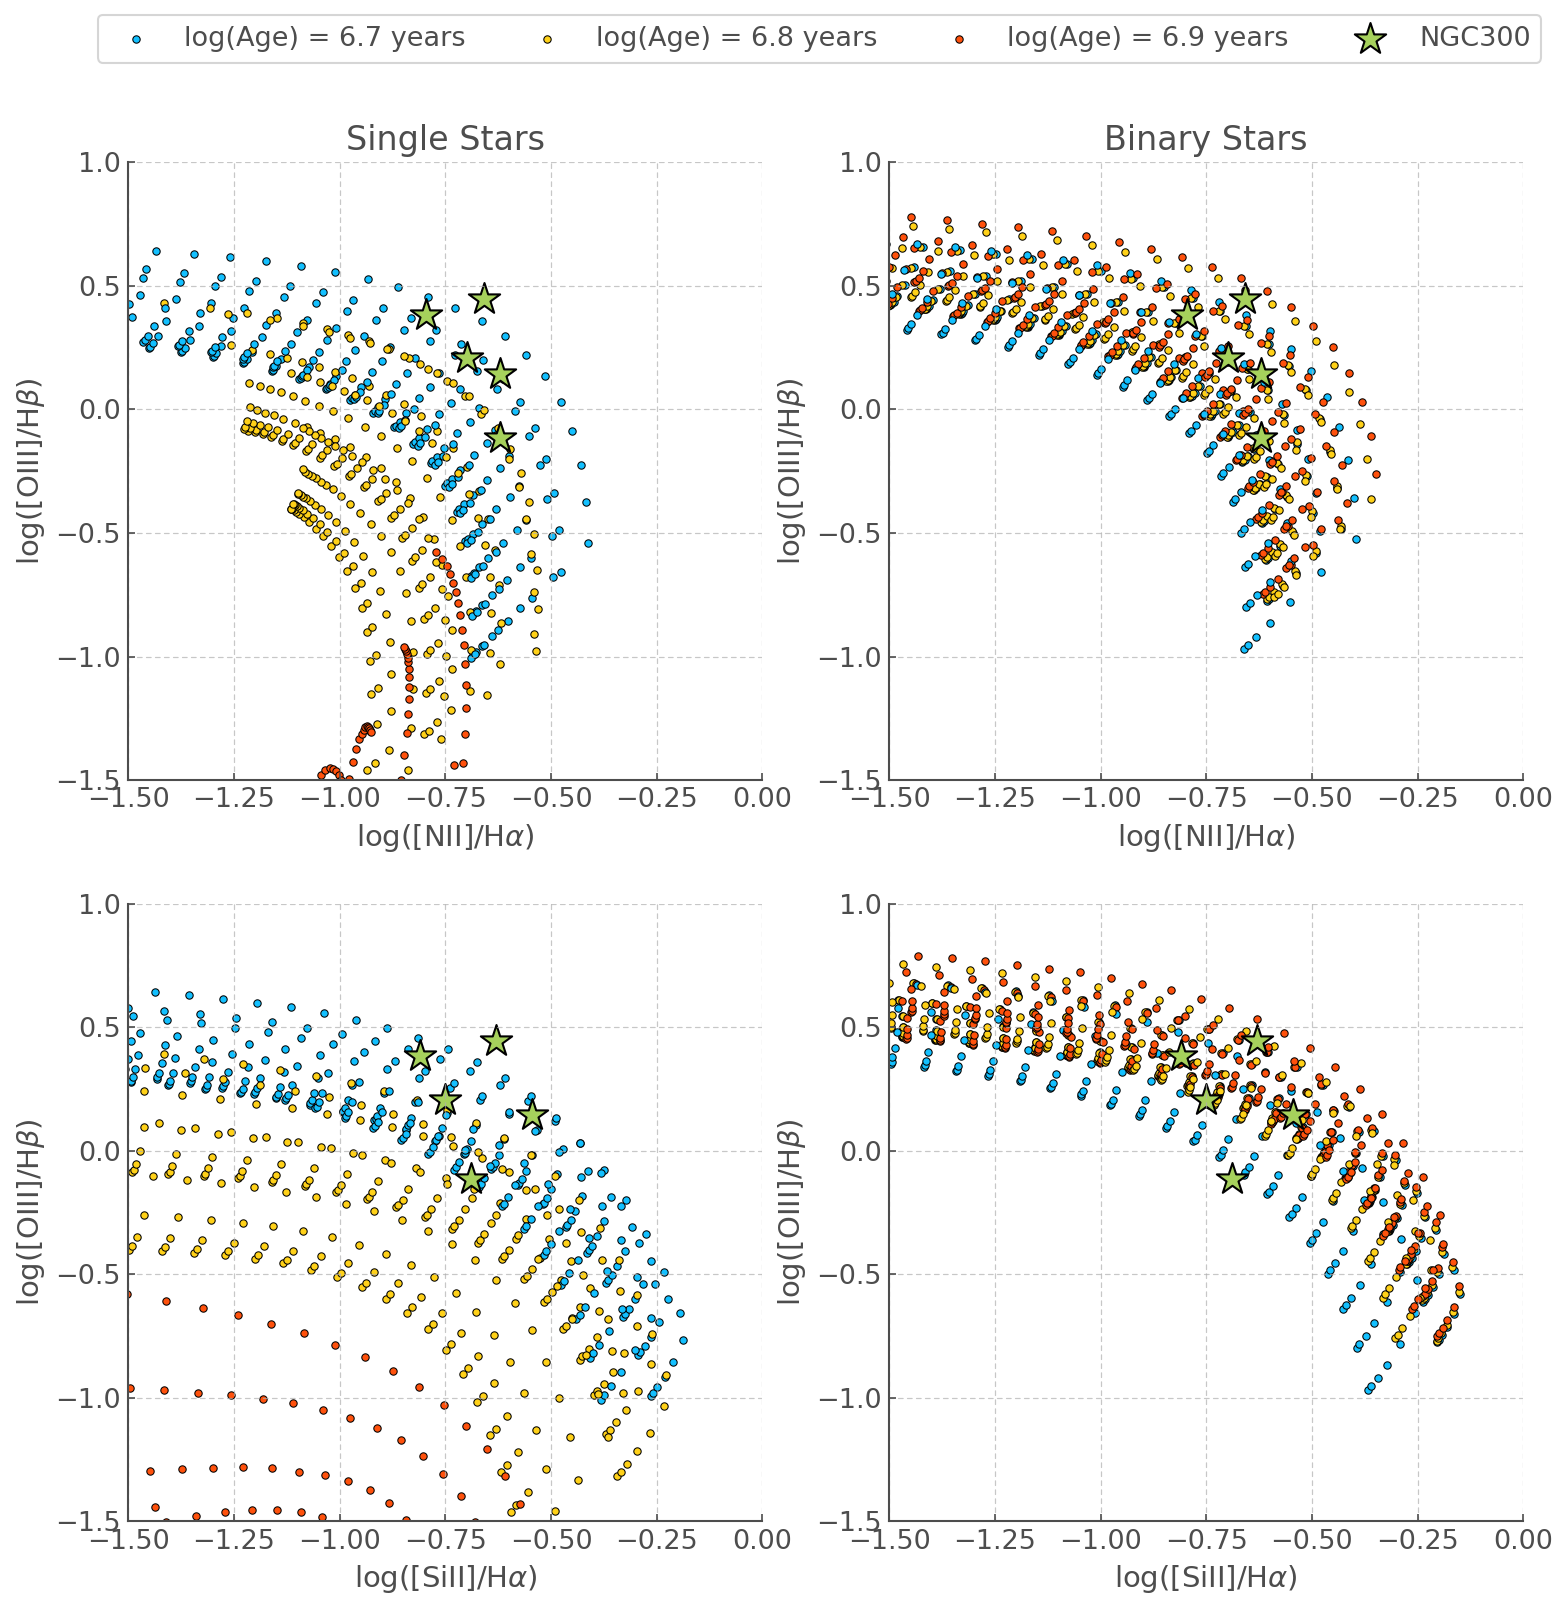

In [51]:
f, ax = plt.subplots(2,2, figsize=(12,12))

for df, i in zip(list_bpt_data_sin, np.arange(len(list_bpt_data_sin))):
    if i == 0:
        bpt_NII_3_ages(df, ax[0,0], legend=True)
        continue
        
    bpt_NII_3_ages(df, ax[0,0])
    
ax[0,0].scatter(sources_bpt.NII_Ha, sources_bpt.OIII_Hb, c=green, marker='*', s=250, ec='k', lw=1, label='NGC300')
ax[0,0].legend(fontsize=13, loc='center right', bbox_to_anchor=(2.25, 1.2), ncol=4)   

for df in list_bpt_data_bin:
    bpt_NII_3_ages(df, ax[0,1])
    
for df in list_bpt_data_sin:
    bpt_SiII_3_ages(df, ax[1,0])
    
for df in list_bpt_data_bin:
    bpt_SiII_3_ages(df, ax[1,1])
    

ax[0,1].scatter(sources_bpt.NII_Ha, sources_bpt.OIII_Hb, c=green, marker='*', s=250, ec='k', lw=1)    
ax[1,0].scatter(sources_bpt.SII_Ha, sources_bpt.OIII_Hb, c=green, marker='*', s=250, ec='k', lw=1)    
ax[1,1].scatter(sources_bpt.SII_Ha, sources_bpt.OIII_Hb, c=green, marker='*', s=250, ec='k', lw=1)    
ax[0,0].set_ylabel(r"log([OIII]/H$\beta$)")
ax[0,0].set_xlabel(r"log([NII]/H$\alpha$)")
ax[0,0].set_title('Single Stars')
ax[0,1].set_ylabel(r"log([OIII]/H$\beta$)")
ax[0,1].set_xlabel(r"log([NII]/H$\alpha$)")
ax[0,1].set_title('Binary Stars')
ax[1,0].set_ylabel(r"log([OIII]/H$\beta$)")
ax[1,0].set_xlabel(r"log([SiII]/H$\alpha$)")
ax[1,1].set_ylabel(r"log([OIII]/H$\beta$)")
ax[1,1].set_xlabel(r"log([SiII]/H$\alpha$)")



for axis in ax.reshape(4):
    axis.set_ylim([-1.5,1.0])
    axis.set_xlim([-1.5,0.0])
    
#plt.savefig('BPT_NGC300.png', dpi=150)

# Red Bumps

In [52]:
spec_118 = pd.read_csv('./data/spectrum_118.dat')
spec_119 = pd.read_csv('./data/spectrum_119.dat')

sed_006=load.model_output("./data/spectra-bin-imf135_300.z006.dat")
sed_006=sed_006[(sed_006.WL>=spec_118.WL[0]) & (sed_006.WL<=spec_118.WL.iloc[-1]) ]


L_sun = 3.846*10**(33) 
area = ((2*10**6 * 3.08*10**18)**2) * 4 * np.pi
scale = L_sun/area*10**20 #factor of 10 to the 20 in paper see label fig 2 

wlmin=5750
wlmax=5875
mask_sed = (sed_006.WL > wlmin) & (sed_006.WL < wlmax)
mask_118 = (spec_118.WL > wlmin) & (spec_118.WL < wlmax)
mask_119 = (spec_119.WL > wlmin) & (spec_119.WL < wlmax)

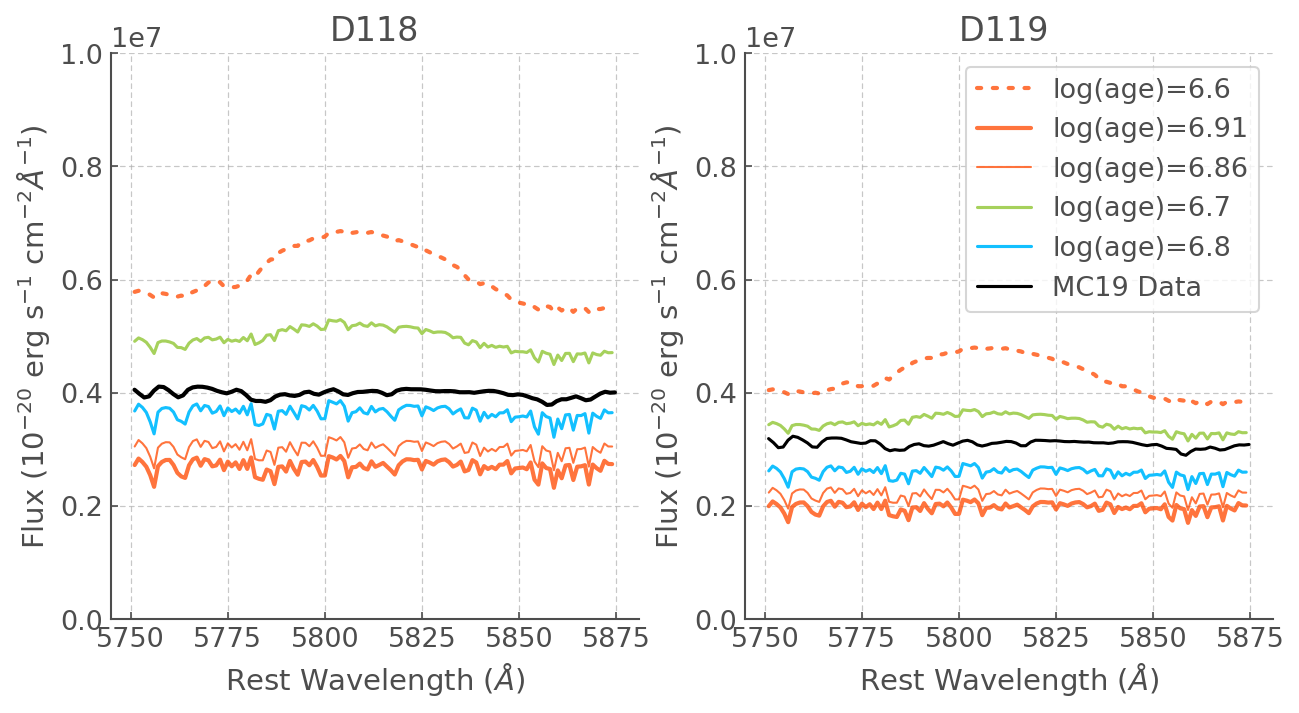

In [53]:
f, ax = plt.subplots(ncols = 2, figsize=(10,5))

ax[0].plot(sed_006.WL[mask_sed], (sed_006['6.6'][mask_sed])*scale,  alpha=0.8, color=red, ls=":", lw=2)
ax[0].plot(sed_006.WL[mask_sed], (sed_006['6.9'][mask_sed]*0.9+sed_006['7.0'][mask_sed]*0.1)*scale*0.75, color=red, lw=2, alpha=0.8)
ax[0].plot(sed_006.WL[mask_sed], (sed_006['6.8'][mask_sed]*0.4+sed_006['6.9'][mask_sed]*0.6)*scale*0.75, lw=1, alpha=0.8, color=red)

ax[0].plot(sed_006.WL[mask_sed], (sed_006['6.7'][mask_sed])*scale, color=green)
ax[0].plot(sed_006.WL[mask_sed], (sed_006['6.8'][mask_sed])*scale*0.8,  color=blue)

ax[0].plot(spec_118.WL[mask_118], spec_118.F[mask_118], c='k', lw=2)
ax[0].set_title('D118')
ax[0].set_ylim([0, 1*10**(7)])
ax[0].set_ylabel(r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2} \AA^{-1}$)')
ax[0].set_xlabel(r'Rest Wavelength ($\AA$)')
#ax[0].legend()

ax[1].plot(sed_006.WL[mask_sed], (sed_006['6.6'][mask_sed])*scale*0.7,  alpha=0.8, color=red, ls=":", lw=2, label = 'log(age)=6.6')
ax[1].plot(sed_006.WL[mask_sed], (sed_006['6.9'][mask_sed]*0.9+sed_006['7.0'][mask_sed]*0.1)*scale*0.55, color=red, lw=2, alpha=0.8, label = 'log(age)=6.91')
ax[1].plot(sed_006.WL[mask_sed], (sed_006['6.8'][mask_sed]*0.4+sed_006['6.9'][mask_sed]*0.6)*scale*0.55, lw=1, alpha=0.8, color=red, label = 'log(age)=6.86')
ax[1].plot(sed_006.WL[mask_sed], (sed_006['6.7'][mask_sed])*scale*0.7, color=green, label = 'log(age)=6.7')
ax[1].plot(sed_006.WL[mask_sed], (sed_006['6.8'][mask_sed])*scale*0.57, color=blue, label = 'log(age)=6.8')

ax[1].plot(spec_119.WL[mask_119], spec_119.F[mask_119], c='k', label='MC19 Data')
ax[1].set_ylim([0, 1*10**(7)])
ax[1].set_xlabel(r'Rest Wavelength ($\AA$)')
ax[1].set_ylabel(r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2} \AA^{-1}$)')
ax[1].set_title('D119 ')
ax[1].legend(fontsize=13)
#plt.savefig('red_bump.png')

# Geneva Vs BPASS

In [54]:
directory='/home/fste075/Data/Geneva_models/isochronesZ014_mostrecent/'
file_names = [line[:-1] for line in  open(directory+"file_list", 'r')]

hrd_006_sin = load.model_output('/home/fste075/BPASS_hoki_dev/bpass_v2.2.1_imf135_300/hrs-sin-imf135_300.z006.dat',
                            hr_type='TL')
hrd_006 = load.model_output('/home/fste075/BPASS_hoki_dev/bpass_v2.2.1_imf135_300/hrs-bin-imf135_300.z006.dat',
                            hr_type='TL')

dat_65 = pd.read_csv(directory+file_names[37], sep=r'\s+', engine='python')
dat_66 = pd.read_csv(directory+file_names[38], sep=r'\s+', engine='python')
dat_67 = pd.read_csv(directory+file_names[39], sep=r'\s+', engine='python')
dat_68 = pd.read_csv(directory+file_names[40], sep=r'\s+', engine='python')
dat_69 = pd.read_csv(directory+file_names[41], sep=r'\s+', engine='python')
dat_70 = pd.read_csv(directory+file_names[42], sep=r'\s+', engine='python')

Text(0, 0.5, 'log(L)')

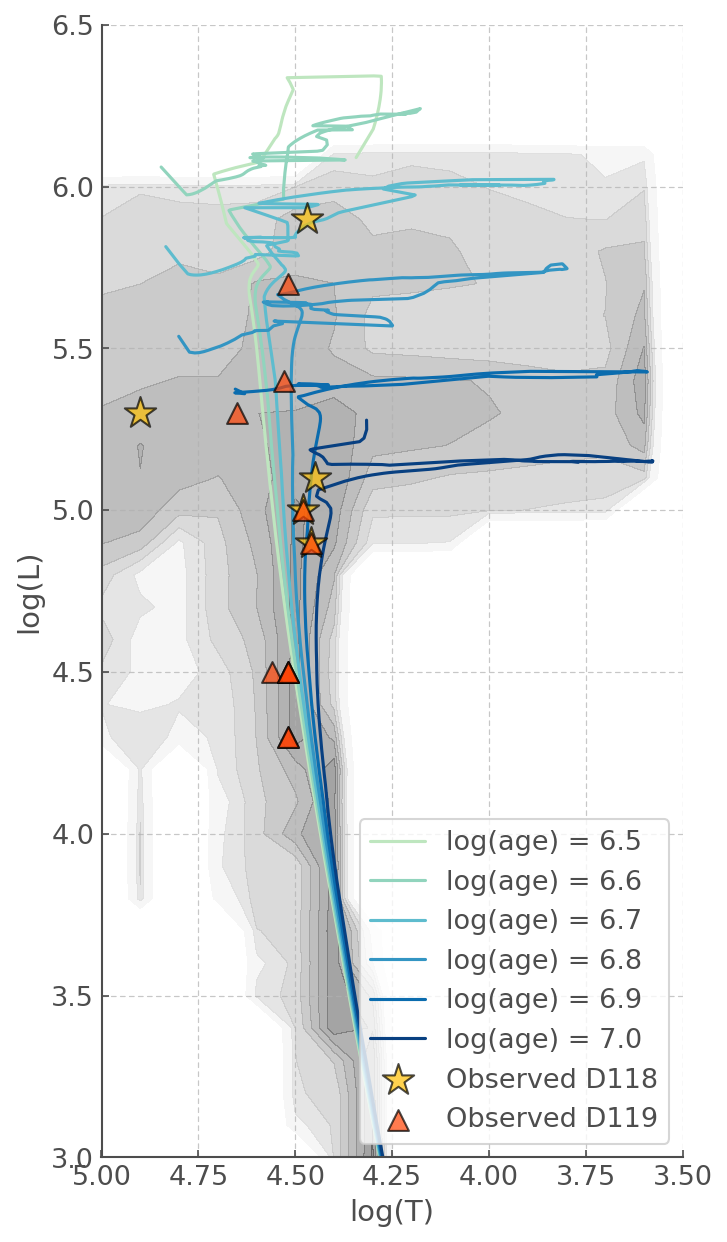

In [55]:
f, ax = plt.subplots(figsize=(5,10))

colors = pl.cm.GnBu(np.linspace(0.3,1,6))
hrd_006.plot(log_age=6.9, loc=ax, alpha=0.5)
ax.plot(dat_65.logTe_c, dat_65.logL, label='log(age) = 6.5', c=colors[0])
ax.plot(dat_66.logTe_c, dat_66.logL, label='log(age) = 6.6', c=colors[1])
ax.plot(dat_67.logTe_c, dat_67.logL, label='log(age) = 6.7', c=colors[2])
ax.plot(dat_68.logTe_c, dat_68.logL, label='log(age) = 6.8', c=colors[3])
ax.plot(dat_69.logTe_c, dat_69.logL, label='log(age) = 6.9', c=colors[4])
ax.plot(dat_70.logTe_c, dat_70.logL, label='log(age) = 7.0', c=colors[5])

ax.scatter(stars[[True if "118" in name else False for name in stars.name ]].logT, 
            stars[[True if "118" in name else False for name in stars.name ]].logL, 
            marker='*', s=250, zorder=10, alpha=0.7, ec='k', color='#ffc004', label='Observed D118')

ax.scatter(stars[[True if "119" in name else False for name in stars.name ]].logT, 
            stars[[True if "119" in name else False for name in stars.name ]].logL, 
            marker='^', s=100, zorder=10, alpha=0.7, ec='k', color='#ff4304', label='Observed D119')

ax.set_xlim([5,3.5])
ax.set_ylim([3,6.5])
ax.legend(fontsize=13, loc=4)
ax.set_xlabel('log(T)')
ax.set_ylabel('log(L)')
#ax.text(4.1, 6.2, "BPASS\nlog(age)=6.9", fontsize=13)
#plt.savefig('geneva_vs_bpass_paper.png', dpi=200)
#plt.savefig('for_twitter.png', dpi=200)

## Comparing BPASS single star models

In [56]:
# We can load an hrd we're gonna use later to get the coordinate, they're class attributes 
agewiz006_sin = AgeWizard(obs_df=stars, 
                     model='./data/hrs-sin-imf135_300.z006.dat')

agewiz008_sin = AgeWizard(obs_df=stars, 
                     model='./data/hrs-sin-imf135_300.z008.dat')

agewiz010_sin = AgeWizard(obs_df=stars, 
                     model='./data/hrs-sin-imf135_300.z010.dat')

/home/fste075/hoki/hoki/age_utils.py:274: RuntimeWarning: invalid value encountered in true_divide
  return distribution / area


In [57]:
def plot_all_pdfs(agewiz, agewiz_sin):
    f, ax = plt.subplots(4, 4, figsize=(17,17))
    plt.subplots_adjust(hspace=0.4)
    axes = ax.reshape(16)

    for source, axis in zip(agewiz.sources, axes):
        axis.step(BPASS_TIME_BINS, agewiz.pdfs[source], color=blue, where='mid')
        axis.fill_between(BPASS_TIME_BINS, agewiz.pdfs[source], step='mid', alpha=0.3, color=blue)
        
        axis.step(BPASS_TIME_BINS, agewiz_sin.pdfs[source], color=yellow, where='mid')
        axis.fill_between(BPASS_TIME_BINS, agewiz_sin.pdfs[source], step='mid', alpha=0.3, color=yellow)
        
        axis.set_title(source)
        axis.set_ylabel('Probability')
        axis.set_xlabel('log(years)')
        axis.set_ylim([0,0.8])    
        axis.set_xlim([6,8.5])       

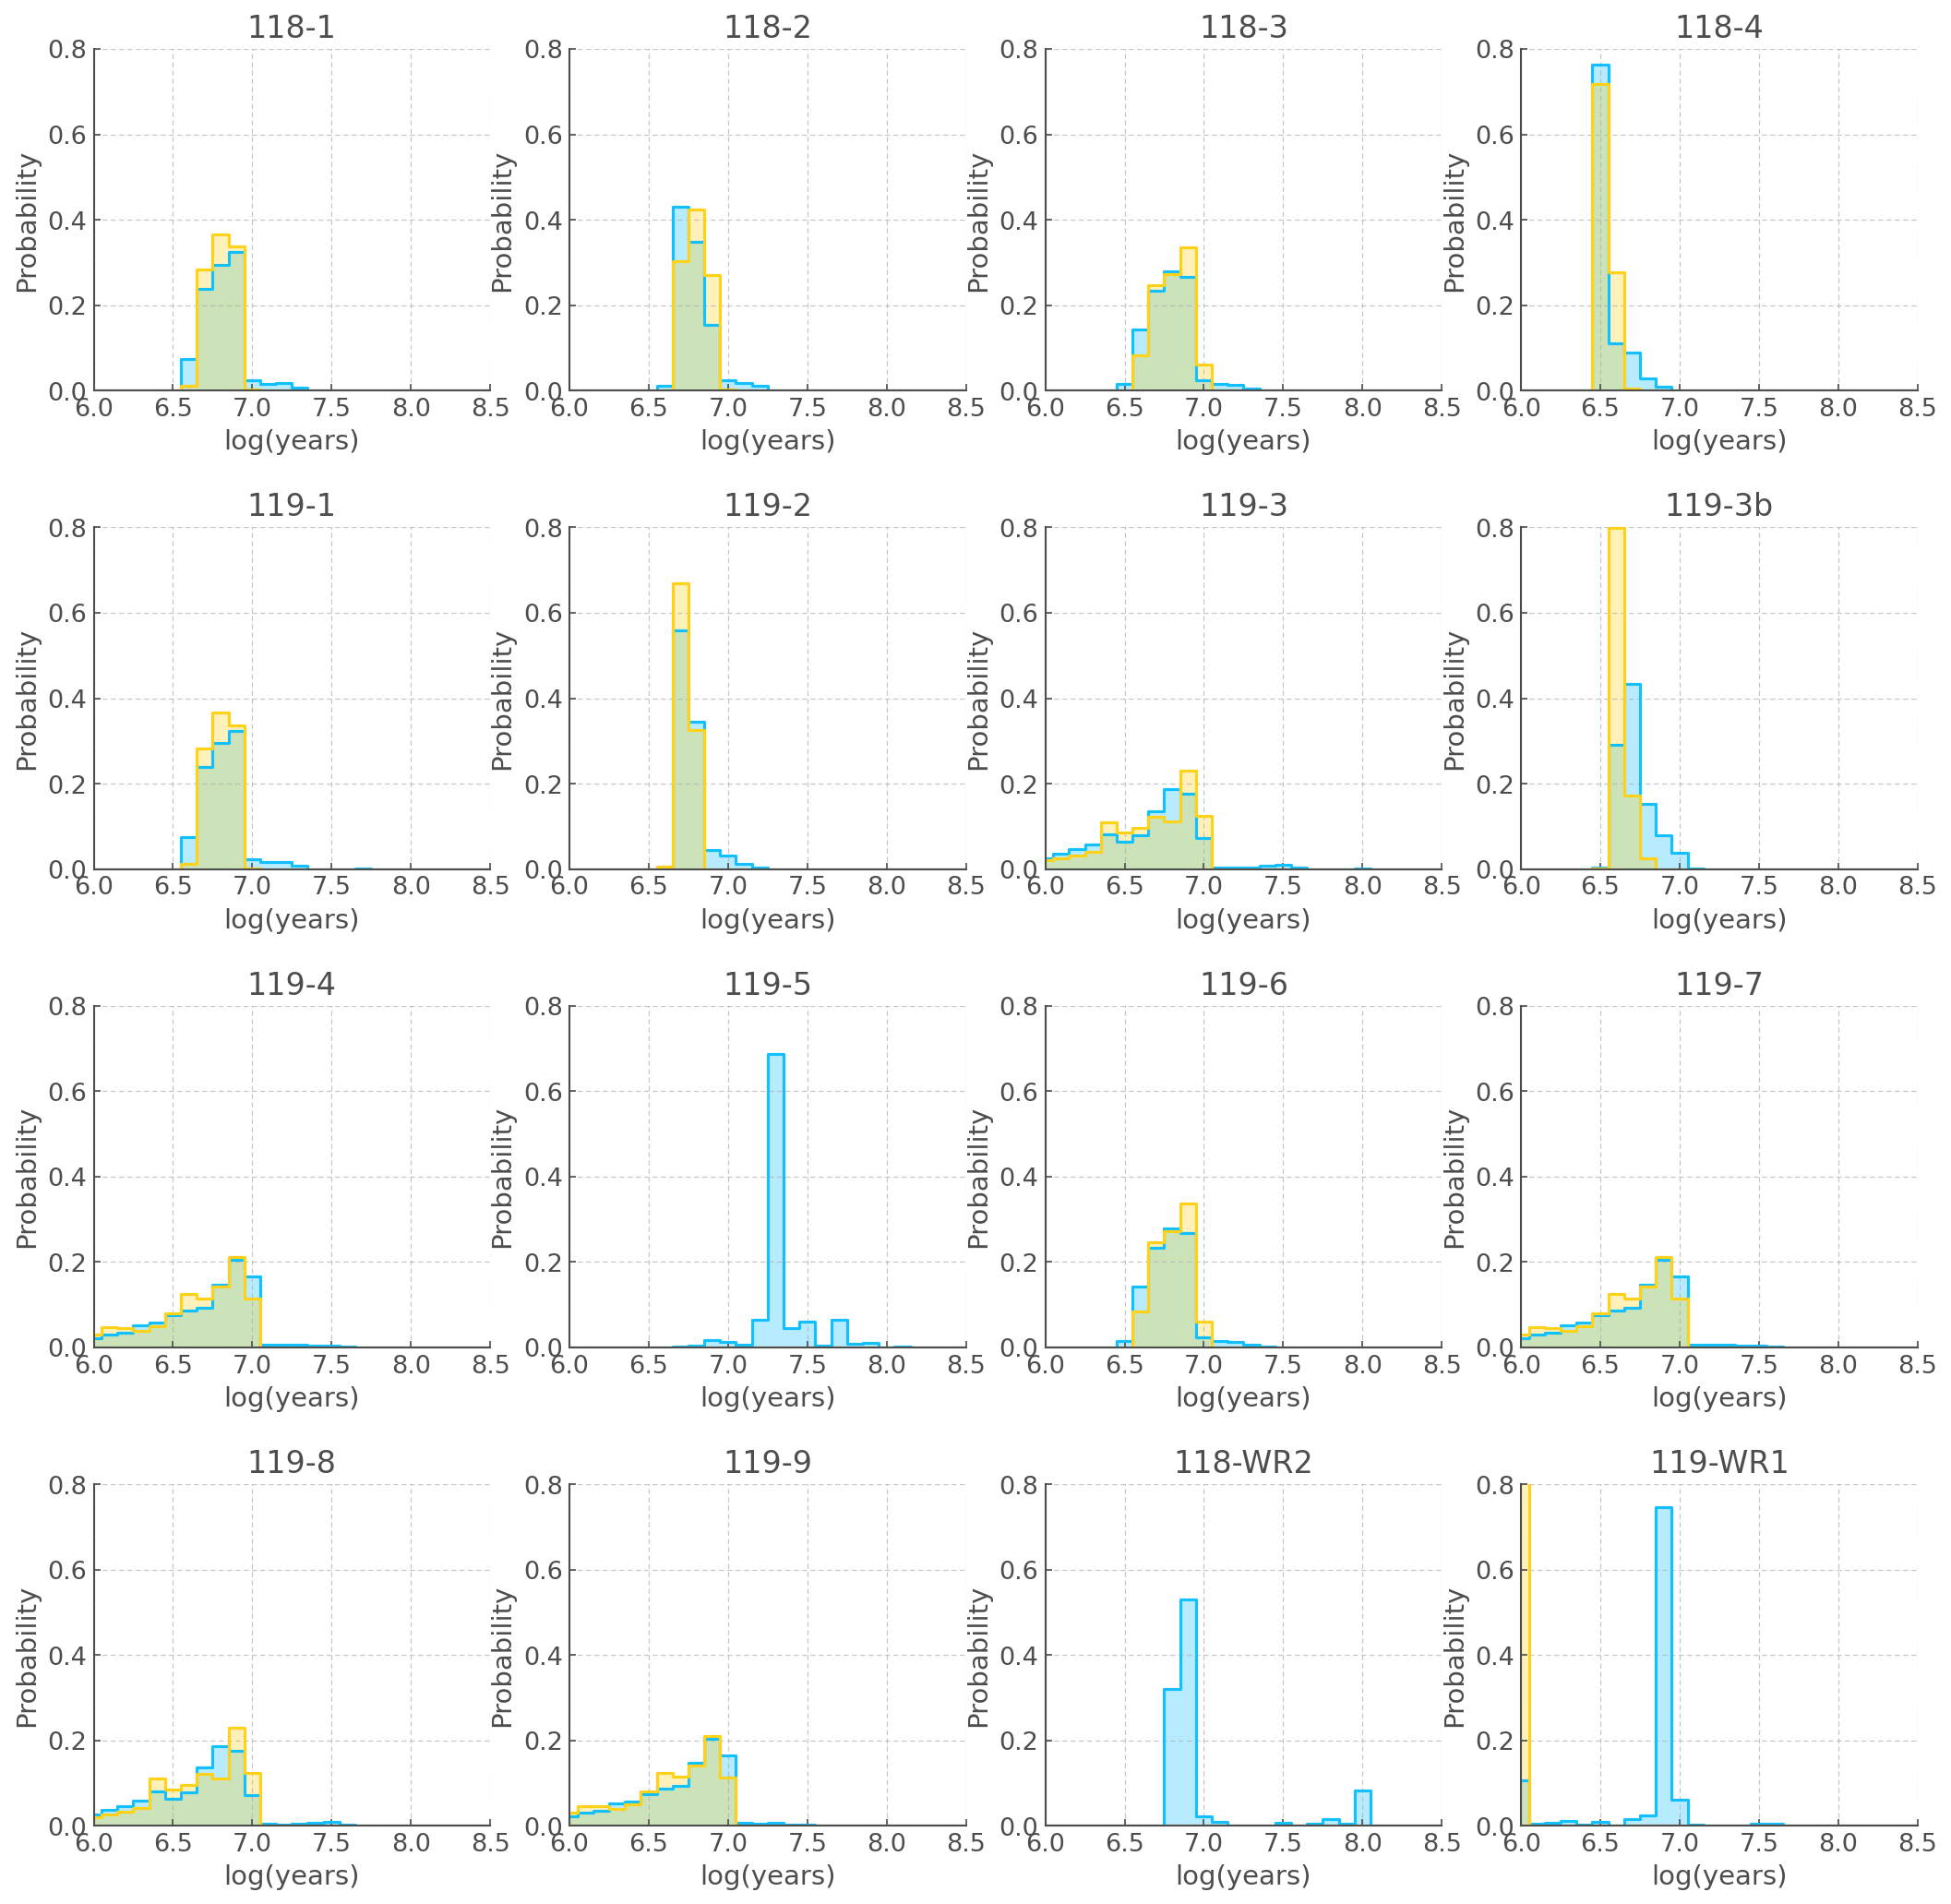

In [58]:
plot_all_pdfs(agewiz006, agewiz006_sin)
#plt.savefig('pdfs_stars_z006_sinVSbin.png', dpi=150)

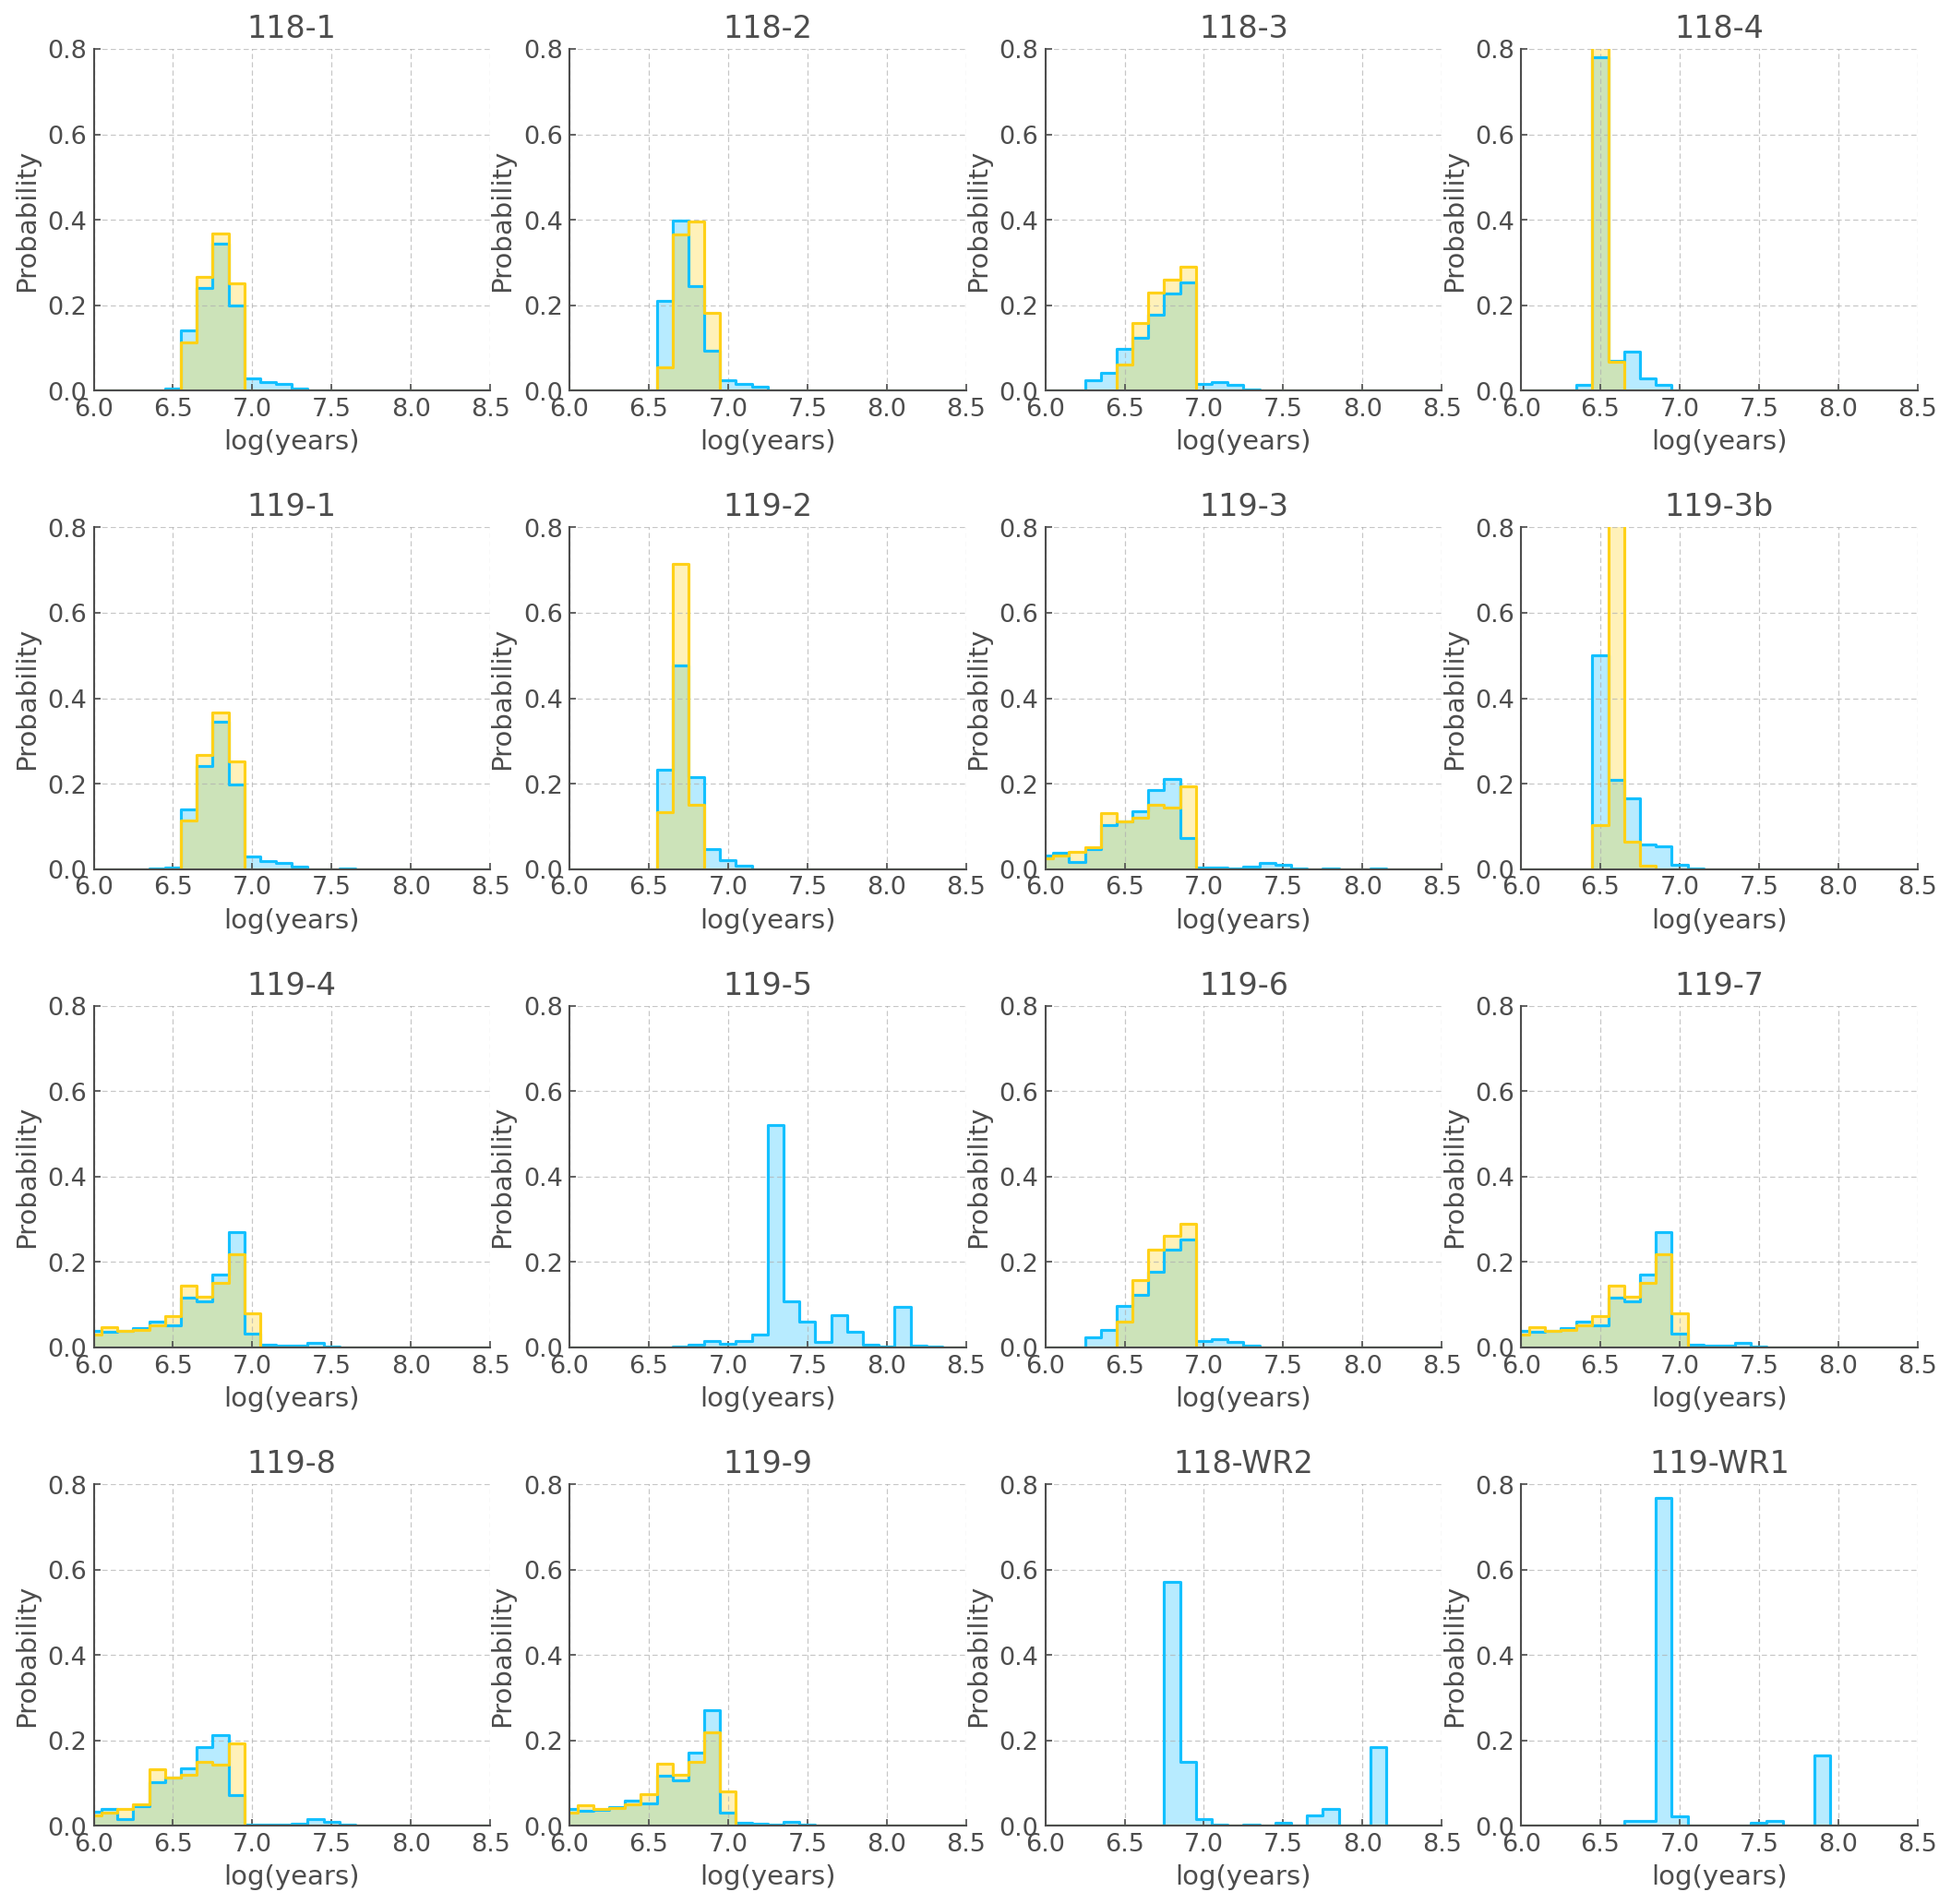

In [59]:
plot_all_pdfs(agewiz008, agewiz008_sin)
#plt.savefig('pdfs_stars_z008_sinVSbin.png', dpi=150)

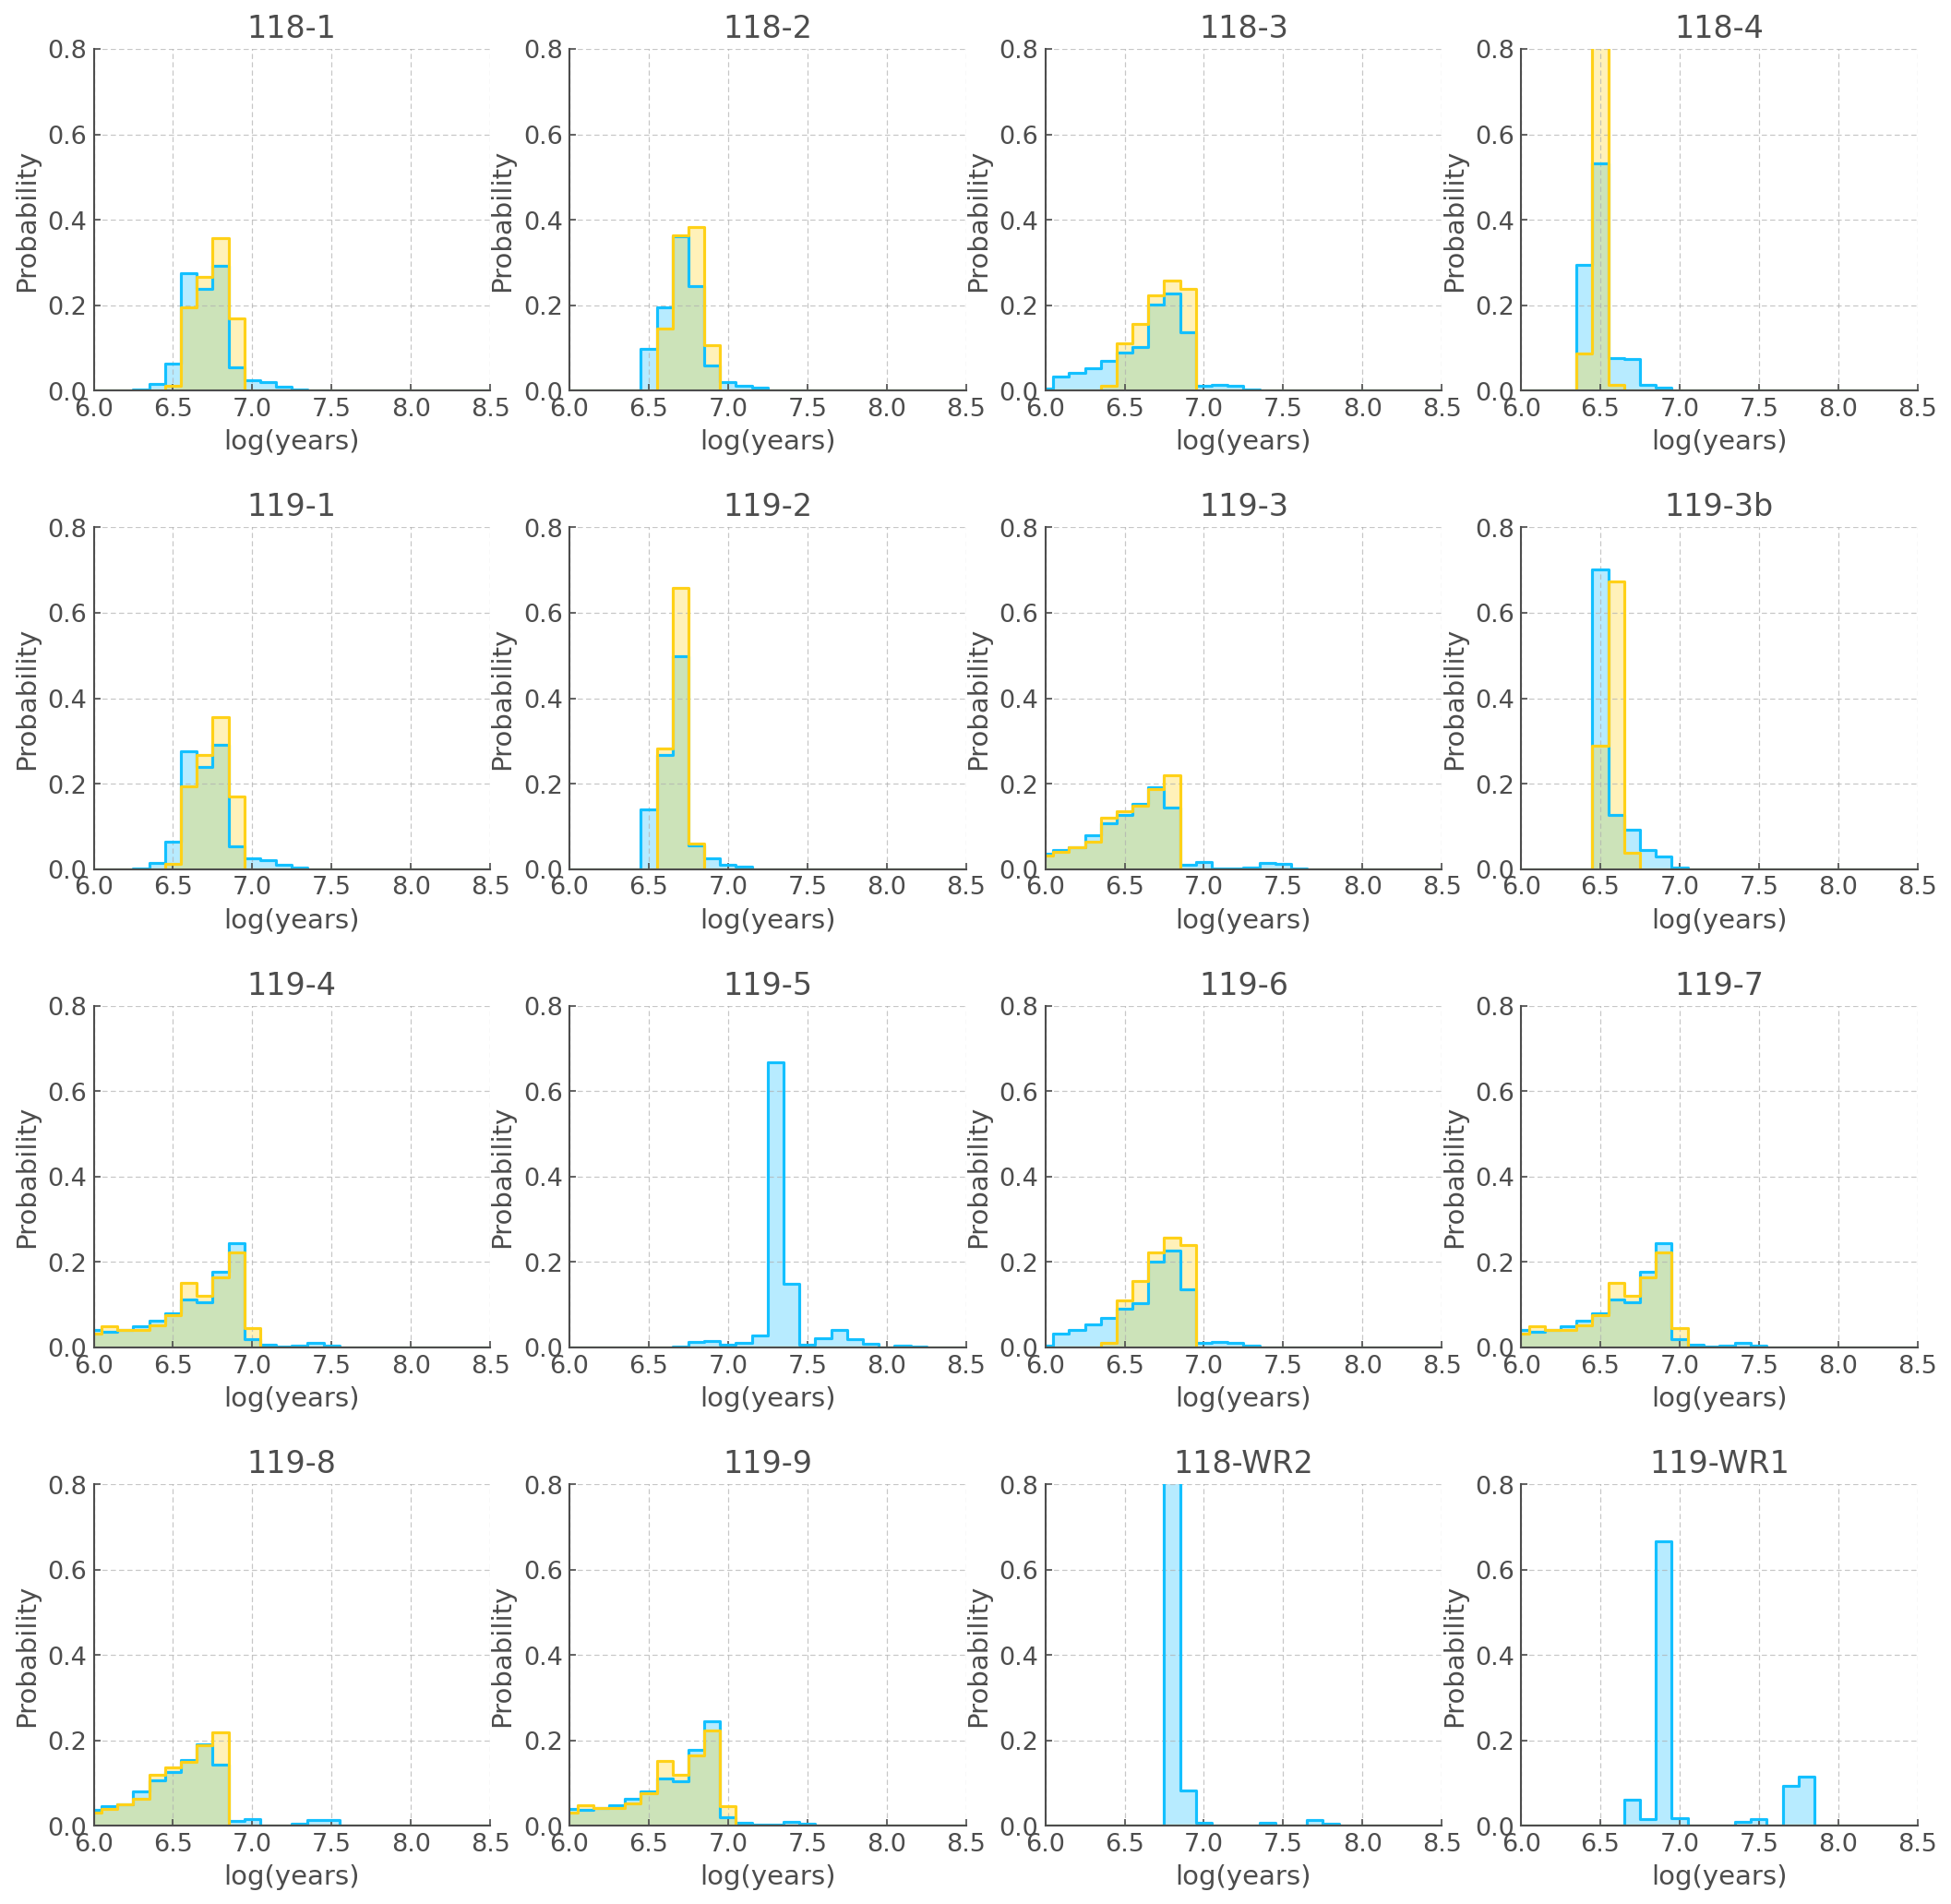

In [60]:
plot_all_pdfs(agewiz010, agewiz010_sin)
#plt.savefig('pdfs_stars_z010_sinVSbin.png', dpi=150)

In [61]:
def plot_combined_sin_vs_bin(agewiz_sin, agewiz_bin, ax):
    # Single stars
    pdf_118_sin, pdf_119_sin, pdf_all_sin = [agewiz_sin.calculate_sample_pdf(not_you=d119+not_you, return_df=True).pdf,
                                                   agewiz_sin.calculate_sample_pdf(not_you=d118+not_you, return_df=True).pdf,
                                                   agewiz_sin.calculate_sample_pdf(not_you=not_you, return_df=True).pdf]


    ax[0].step(BPASS_TIME_BINS, pdf_118_sin, where='mid', alpha=1, color=yellow, lw=3)
    ax[0].fill_between(BPASS_TIME_BINS,  pdf_118_sin, step='mid', alpha=0.3, 
                       color=yellow, hatch='\\', label='dummy')


    ax[1].step(BPASS_TIME_BINS, pdf_119_sin, where='mid', alpha=1, color=yellow, lw=3)
    ax[1].fill_between(BPASS_TIME_BINS,  pdf_119_sin, step='mid', alpha=0.3, 
                       color=yellow, hatch='\\', label='dummy')

    ax[2].step(BPASS_TIME_BINS, pdf_all_sin, where='mid', alpha=1, color=yellow, lw=3)
    ax[2].fill_between(BPASS_TIME_BINS,  pdf_all_sin, step='mid', alpha=0.3, 
                       color=yellow, hatch='\\', label='dummy')
  
    # binaries
    pdf_118_bin, pdf_119_bin, withWR_both_bin = [agewiz_bin.calculate_sample_pdf(not_you=d119+not_you, return_df=True).pdf,
                                                   agewiz_bin.calculate_sample_pdf(not_you=d118+not_you, return_df=True).pdf,
                                                   agewiz_bin.calculate_sample_pdf(not_you=not_you, return_df=True).pdf]

    ax[0].step(BPASS_TIME_BINS, pdf_118_bin, where='mid', alpha=1, color=blue)
    ax[0].fill_between(BPASS_TIME_BINS,  pdf_118_bin, step='mid', alpha=0.2, 
                       color=blue, hatch='\\', label='dummy')


    ax[1].step(BPASS_TIME_BINS, pdf_119_bin, where='mid', alpha=1, color=blue)
    ax[1].fill_between(BPASS_TIME_BINS,  pdf_119_bin, step='mid', alpha=0.2, 
                       color=blue, hatch='\\', label='dummy')

    ax[2].step(BPASS_TIME_BINS, withWR_both_bin, where='mid', alpha=1, color=blue)
    ax[2].fill_between(BPASS_TIME_BINS,  withWR_both_bin, step='mid', alpha=0.2, 
                       color=blue, hatch='\\', label='dummy')
    
    ax[0].set_ylabel('Probability')
    ax[0].set_xlabel('log(ages)')



    ax[1].set_ylabel('Probability')
    ax[1].set_xlabel('log(ages)')

    ax[2].set_ylabel('Probability')
    ax[2].set_xlabel('log(ages)')

    return

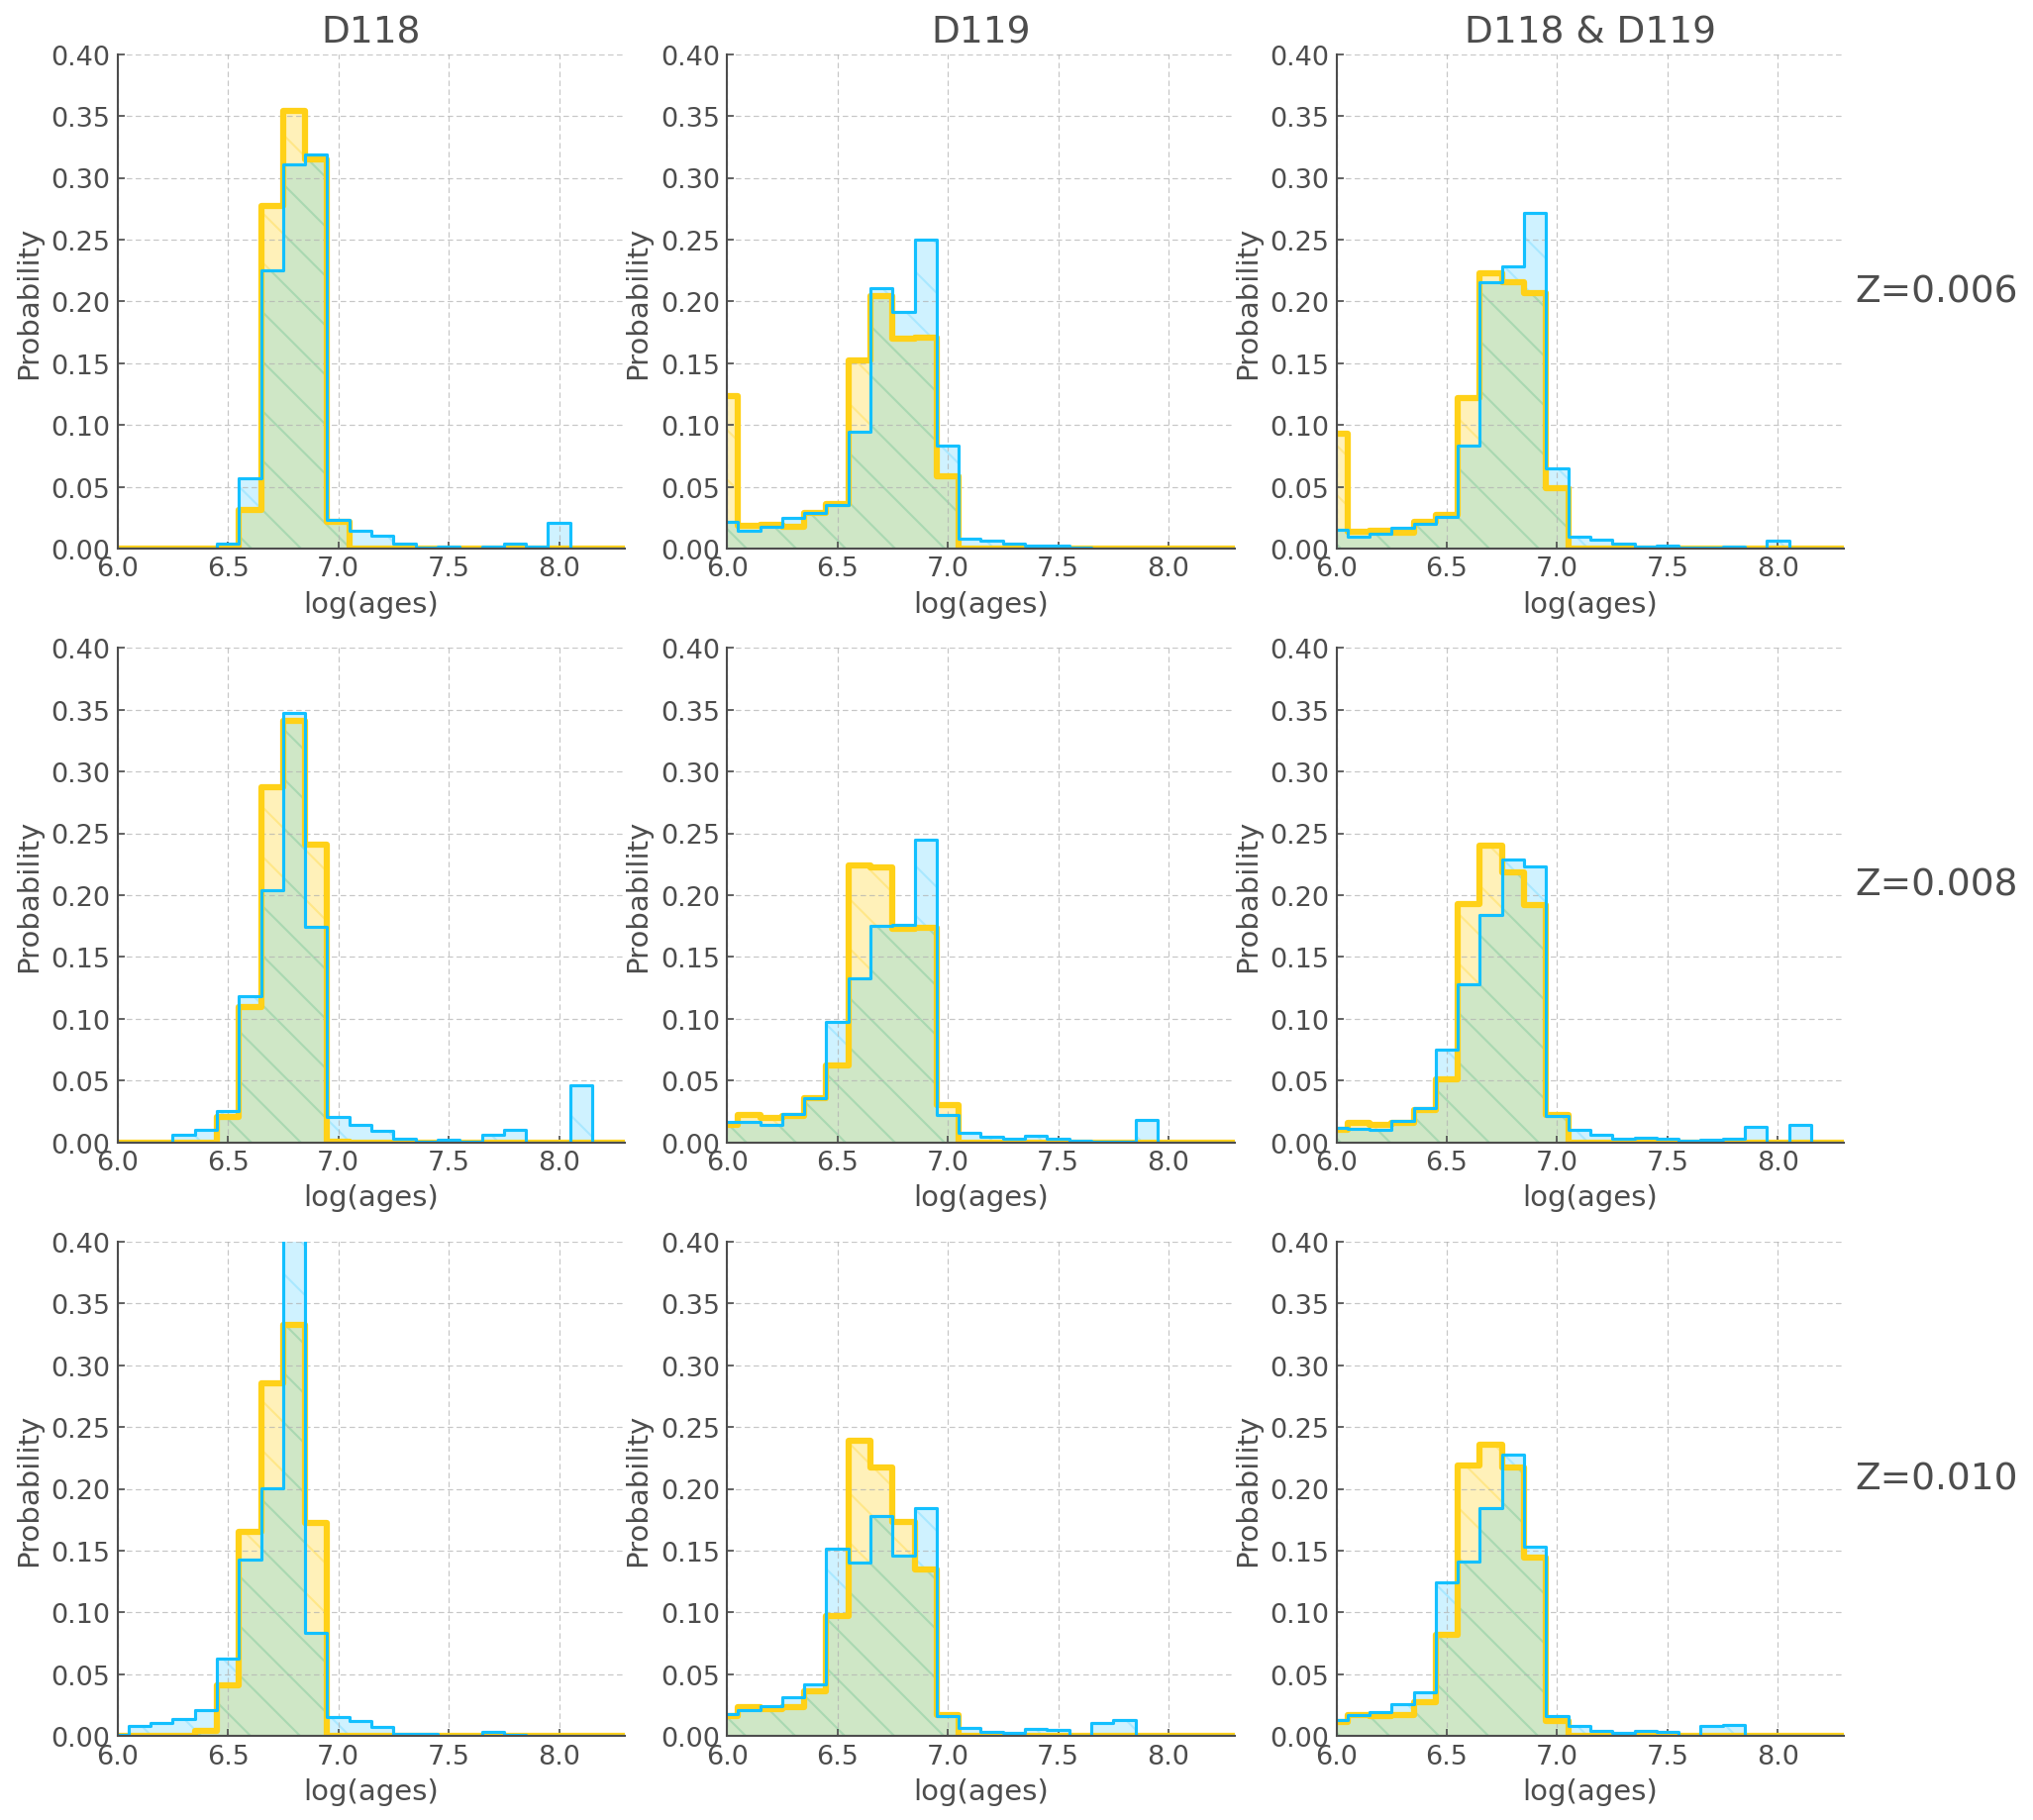

In [62]:
f, ax = plt.subplots(3, 3, figsize=(15,15))

plot_combined_sin_vs_bin(agewiz006_sin, agewiz006, ax[0])
plot_combined_sin_vs_bin(agewiz008_sin, agewiz008, ax[1])
plot_combined_sin_vs_bin(agewiz010_sin, agewiz010, ax[2])

for axis in ax.reshape(9):
    axis.set_ylim([0.0, 0.4])
    axis.set_xlim([6.0, 8.3])

ax[0,0].set_title('D118', fontsize=18)
ax[0,1].set_title('D119', fontsize=18)
ax[0,2].set_title('D118 & D119', fontsize=18)

ax[0,2].text(8.35, 0.20, "Z=0.006", fontsize=18)
ax[1,2].text(8.35, 0.20, "Z=0.008", fontsize=18)
ax[2,2].text(8.35, 0.20, "Z=0.010", fontsize=18)

#plt.savefig('combined_sin_vs_bin.png', dpi=150)

In [63]:
most_likely_ages_sin = pd.DataFrame.from_dict({'name': agewiz006.sources, 
                                           'z006': agewiz006_sin.most_likely_ages, 
                                           'z008': agewiz008_sin.most_likely_ages,
                                           'z010': agewiz010_sin.most_likely_ages}) 

### Table 3 values

In [64]:
most_likely_ages_sin

,name,z006,z008,z010
0,118-1,6.8,6.8,6.8
1,118-2,6.8,6.8,6.8
2,118-3,6.9,6.9,6.8
3,118-4,6.5,6.5,6.5
4,119-1,6.8,6.8,6.8
5,119-2,6.7,6.7,6.7
6,119-3,6.9,6.9,6.8
7,119-3b,6.6,6.6,6.6
8,119-4,6.9,6.9,6.9
9,119-5,6.0,6.0,6.0


In [65]:
p_ages_679_sin = pd.DataFrame.from_dict({'z006': agewiz006_sin.calculate_p_given_age_range([6.7,6.9]), 
                                     'z008': agewiz008_sin.calculate_p_given_age_range([6.7,6.9]),
                                     'z010': agewiz010_sin.calculate_p_given_age_range([6.7,6.9])}) 

In [66]:
p_ages_679_sin.round(2)

,z006,z008,z010
name,,,
118-1,0.99,0.89,0.79
118-2,1.00,0.94,0.85
118-3,0.86,0.78,0.72
118-4,0.01,0.00,0.00
119-1,0.99,0.89,0.79
119-2,0.99,0.87,0.72
119-3,0.46,0.49,0.41
119-3b,0.20,0.07,0.04
119-4,0.47,0.49,0.51
